1. Проект.

  1.1. Постановка задачи. 
  
  В данном проекте я хочу сравнить 2 метода transfer learning (fine-tuning и feature exctraction) для задачи классификиции для моделей доступных в библиотеке pytorch

  1.2. Ожидания.
  
  В результате этой работы я ожидаю увидеть какой из методов дает лучшее качество по validation accuracy. Так же более подробно посмотрю на получившиеся данные под разными углами и сравню дополнительно количество параметров, время обучения, вес получившихся моделей.

2.  Наработки

  По данной теме я искал статьи, но не нашел для себя ответа что же лучше использовать. Были [статья](https://aclanthology.org/W19-4302.pdf), где брали конкретную модель и применяли к ней уже fine tuning. Я же хочу понять как влияет на качество в среднем для некоторого набора моделей применение ft и fe.

3.  Источник данных

  3.1.Свои данные я взял с kaggle. Датасет представляет набор скриншотов из всем известного мультсериала Том и Джерри. Датасет был относительно свежий (7 месяцев). Там 4 класса : Том, Джерри, ТомиДжерри вместе, никого нет. Каждому классу соотвествовала папка с картинками 1280 на 720.
  
  3.2.Показать картинки

4. Подготовка данных

  4.1. Не было разбиения на train/val папки, поэтому пришлось предобрабатывать датасет и разбивать самому. 

  4.2. Преобразования были Autoaugment(Imagenet), Resizee (до размера картинки на которых училась сетка), ToTensor, Normalize. Для тестовой выборки не делал Autoaugment

  4.2. Тк наблюдался дисбаланс в категориях, то я сделал WeightedRandomSampler который при добавлении в Dataloader затавлял его сэмплировать в зависимости от веса либо больше элементов класса, либо меньше. Таким образом выравнил дисбаланс. Но из-за этого время обучения увеличилось, тк количество элеметнов в train loader оказалось почти в 2 раза больше.

5. Модели

  Модели были выбраны из оф [документации](https://pytorch.org/vision/stable/models.html) пайторч. Это обусловлено тем, что привык работать с пайторчем и удобно было использовать готовое решение по моделям от этой же библиотеки. 

  Изначально хотел все модели попробовать обучить, но некоторые модели не смог запустить, а времени на отладку не было.

  MaxVit -  ошибка с размерностями, хотя на других проблем не было.
  VisionTransformer - оказалось что на вход ему поступала картинка не ужатая до квадрата, а прямоугольная, и так же на других моделях это никак не отразилось, только на этой.

  5.1. ГиперПараметры моделей

  Optimizer -  Adam. Тк согласно исследованиям это пока что лучший оптимизатор. 

  + weight optimization - L2  регуляризация
  + amsgrad - улучшает сходимость adam

  sheduler - StepLr -  с 5 эпохи уменьшал  lr  в 10 раз

  batchsize - от 1000 до 10

  epochs = 10 - посмотрел, все модели примерно сходятся к 10й эпохе

6. Результаты

  relplot - на оси абсцисс year, ординат - max_val_acc. 

7. Выводы
  
  FE - хуже по метрикам , но в среднем легче и быстрее обучаются

  FT - лучше по метрикам, но в среднем тяжелее и дольше обучаются

  Мобильные легкие модели быстро обучаются в FT  достигают отличных результатов


# 1.Импорт модулей

In [ ]:
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

%matplotlib inline

# модули библиотеки PyTorch
import torch
from torchvision import datasets, transforms, models
import torch.nn as nn
import torch.nn.functional as F  # Functional
from torchsummary import summary
from torch.utils.data import DataLoader, Dataset, random_split
from torch.utils.data.sampler import WeightedRandomSampler

# # метрика качества 
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import classification_report
# from sklearn.metrics import f1_score

from sklearn.model_selection import train_test_split

import cv2
from PIL import Image
import pathlib as p

from sklearn.preprocessing import LabelEncoder

from collections import Counter

import gc

import seaborn as sns
from IPython.display import clear_output
import time


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
seed = 333
np.random.seed(seed)
PROJECT_PATH = '/content/drive/MyDrive/Colab Notebooks/MIPT ФПМИ DS/3.ML/ДЗ/Project_image_classification/'

# 2.Загрузка датасета

## Загрузить с Каггла

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 68 bytes


In [ ]:
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d balabaskar/tom-and-jerry-image-classification

100% 435M/435M [00:24<00:00, 19.4MB/s]
100% 435M/435M [00:24<00:00, 18.4MB/s]


In [ ]:
!unzip tom-and-jerry-image-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: tom_and_jerry/tom_and_jerry/jerry/frame2793.jpg  
  inflating: tom_and_jerry/tom_and_jerry/jerry/frame2794.jpg  
  inflating: tom_and_jerry/tom_and_jerry/jerry/frame2795.jpg  
  inflating: tom_and_jerry/tom_and_jerry/jerry/frame2796.jpg  
  inflating: tom_and_jerry/tom_and_jerry/jerry/frame2797.jpg  
  inflating: tom_and_jerry/tom_and_jerry/jerry/frame2798.jpg  
  inflating: tom_and_jerry/tom_and_jerry/jerry/frame2799.jpg  
  inflating: tom_and_jerry/tom_and_jerry/jerry/frame2800.jpg  
  inflating: tom_and_jerry/tom_and_jerry/jerry/frame2801.jpg  
  inflating: tom_and_jerry/tom_and_jerry/jerry/frame2802.jpg  
  inflating: tom_and_jerry/tom_and_jerry/jerry/frame2803.jpg  
  inflating: tom_and_jerry/tom_and_jerry/jerry/frame2804.jpg  
  inflating: tom_and_jerry/tom_and_jerry/jerry/frame2805.jpg  
  inflating: tom_and_jerry/tom_and_jerry/jerry/frame2806.jpg  
  inflating: tom_and_jerry/tom_and_jerry/jerry/frame2807.jpg  
  in

# 3.Подготовка датасета



Определяю директории для данных в папках. Вижу, что после загрузки данных у нас появились папки без разбиения на train / val  как это обычно бывает в датасетах. Поэтому датасет надо будет разбить на подвыборки train/ val далеее в ноутбуке

In [ ]:
ds_dir = p.Path('/content/tom_and_jerry/tom_and_jerry')

Посмотрю на одну картинку

In [ ]:
imgs = sorted(ds_dir.rglob('*.jpg'))
imgs[0]

PosixPath('/content/tom_and_jerry/tom_and_jerry/jerry/frame100.jpg')

In [ ]:
image = Image.open(str(imgs[0]))
# image # так тоже можно посмотреть картинку, но она полноразмерная будет

In [ ]:
p = transforms.Compose([transforms.Resize((48,48))])
p(image).size

(48, 48)

In [ ]:
pp = transforms.Compose([transforms.Pad([0,280], fill = 0, padding_mode = 'symmetric')])
ii =  pp(image)
print(ii.size)
iii = p(ii)
print(iii.size)

(1280, 1280)
(48, 48)


In [ ]:
ii = image.resize((720,720))

In [ ]:
ii.size

(720, 720)

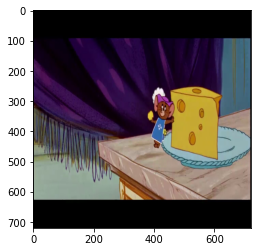

In [ ]:
plt.imshow(ii, cmap = 'gray')

In [ ]:
for img in imgs:
  i

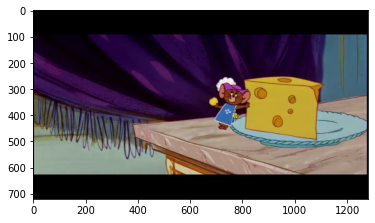

In [ ]:
plt.imshow(image, cmap = 'gray')

Свойства картинки

In [ ]:
print(f'format = {image.format}, size = {image.size}, mode = {image.mode}')

format = JPEG, size = (1280, 720), mode = RGB


## Dataset without transformations

Инициализация датасета без предобработки

In [ ]:
train_data_without_transformations = datasets.ImageFolder(ds_dir)

Длина датасета:

In [ ]:
len(train_data_without_transformations)

5478

Посмотрим на изображения без предобработки

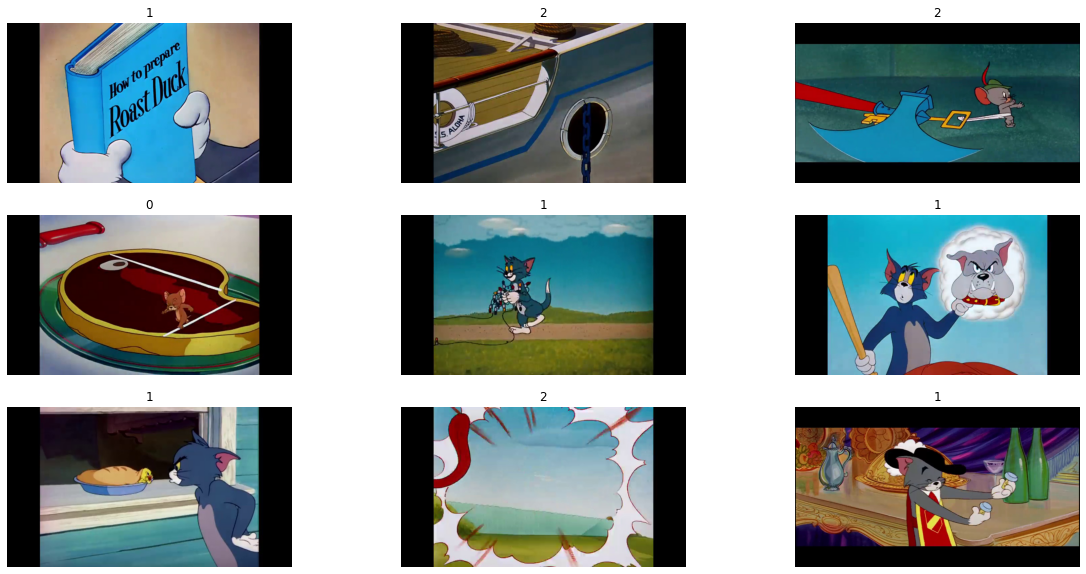

In [ ]:
def show_imgs(train_data):
    f, axes= plt.subplots(3, 3, figsize=(20,10))
    for row in range(3):
      for col in range(3):
        rand_pic = np.random.choice(len(train_data_without_transformations), size=1, replace=False)
        axes[row][col].imshow(train_data[rand_pic.item()][0], cmap='gray')
        axes[row][col].set_title(train_data[rand_pic.item()][1])
        axes[row][col].axis('off')
    plt.show()

show_imgs(train_data_without_transformations)

## Train/val split

Разобью датасат на сабсеты train/val в пропорции 80/20

In [ ]:
train_data, val_data = random_split(train_data_without_transformations, [0.8, 0.2], generator=torch.Generator().manual_seed(seed))

In [ ]:
type(train_data)

torch.utils.data.dataset.Subset

## Dataset with transformations

Теперь сделаем датасет с трансформациями

Поставим количество пикселей на вход в зависиммости от модели:

DenseNet121, VGG16  = 224;
VIT_b_14 = 518;
VIT_b_16 = 224;
inceptionv3 = 299

In [ ]:
# тк у нас у картинки 1280 x 720 пикселей, то нужно сделать ресайз до размеров на которых обучалась модель
input_size = 224
# input_size = 299

In [ ]:
transform_train = transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.AutoAugment(),
        transforms.ToTensor(), # тут так же rescale [0 to 1]  внутри этой операции
        transforms.Normalize(mean=[0.485, 0.456, 0.406], # это среднее и стандартное отклонение всего датасета imagenet
                              std=[0.229, 0.224, 0.225]),
])
# отдельный для теста беза аугментации
transform_val = transforms.Compose([   
        transforms.Resize(input_size),                       
        transforms.ToTensor(), # тут так же rescale [0 to 1]  внутри этой операции
         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225]),
])

Применю соотв трансформации для subsets 

In [ ]:
train_data.dataset.transform = transform_train
val_data.dataset.transform = transform_val

In [ ]:
train_data.dataset[0][0].shape

torch.Size([3, 224, 398])

In [ ]:
train_data[0][0].shape

torch.Size([3, 224, 398])

Длины получившихся сабсетов

In [ ]:
print(len(train_data),
      '\n',len(val_data)
      )

4383 
 1095


Проверим что трансформации применились к Subset. Должны получиться тензоры

In [ ]:
train_data[0]

(tensor([[[-1.1760, -1.0733, -1.0733,  ..., -1.0733, -1.0904, -1.2103],
          [-1.1760, -1.0733, -1.0733,  ..., -1.0733, -1.0904, -1.2103],
          [-1.1760, -1.0733, -1.0733,  ..., -1.0733, -1.0904, -1.2103],
          ...,
          [-1.2274, -1.1075, -1.0904,  ..., -1.0904, -1.1075, -1.2445],
          [-1.2274, -1.1075, -1.0904,  ..., -1.0904, -1.1075, -1.2445],
          [-1.2274, -1.1075, -1.0904,  ..., -1.0904, -1.1075, -1.2445]],
 
         [[-0.0049,  0.1001,  0.1001,  ...,  0.3452,  0.3277,  0.2052],
          [-0.0049,  0.1001,  0.1001,  ...,  0.3452,  0.3277,  0.2052],
          [-0.0049,  0.1001,  0.1001,  ...,  0.3452,  0.3277,  0.2052],
          ...,
          [-0.0749,  0.0476,  0.0651,  ...,  0.1001,  0.0826, -0.0574],
          [-0.0749,  0.0476,  0.0651,  ...,  0.1001,  0.0826, -0.0574],
          [-0.0749,  0.0476,  0.0651,  ...,  0.1001,  0.0826, -0.0574]],
 
         [[ 0.2696,  0.3742,  0.3742,  ...,  0.4962,  0.4788,  0.3568],
          [ 0.2696,  0.3742,

In [ ]:
val_data[0]

(tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044,

In [ ]:
# встроенный метод получает нужнуй элемент по индексу
img, lab = train_data.__getitem__(0)
print(img.shape, lab)

torch.Size([3, 224, 398]) 1


In [ ]:
img, lab

(tensor([[[-1.1760, -1.0733, -1.0733,  ..., -1.0733, -1.0904, -1.2103],
          [-1.1760, -1.0733, -1.0733,  ..., -1.0733, -1.0904, -1.2103],
          [-1.1760, -1.0733, -1.0733,  ..., -1.0733, -1.0904, -1.2103],
          ...,
          [-1.2274, -1.1075, -1.0904,  ..., -1.0904, -1.1075, -1.2445],
          [-1.2274, -1.1075, -1.0904,  ..., -1.0904, -1.1075, -1.2445],
          [-1.2274, -1.1075, -1.0904,  ..., -1.0904, -1.1075, -1.2445]],
 
         [[-0.0049,  0.1001,  0.1001,  ...,  0.3452,  0.3277,  0.2052],
          [-0.0049,  0.1001,  0.1001,  ...,  0.3452,  0.3277,  0.2052],
          [-0.0049,  0.1001,  0.1001,  ...,  0.3452,  0.3277,  0.2052],
          ...,
          [-0.0749,  0.0476,  0.0651,  ...,  0.1001,  0.0826, -0.0574],
          [-0.0749,  0.0476,  0.0651,  ...,  0.1001,  0.0826, -0.0574],
          [-0.0749,  0.0476,  0.0651,  ...,  0.1001,  0.0826, -0.0574]],
 
         [[ 0.2696,  0.3742,  0.3742,  ...,  0.4962,  0.4788,  0.3568],
          [ 0.2696,  0.3742,

Посмотрим на получившиеся изображения с трансформациями

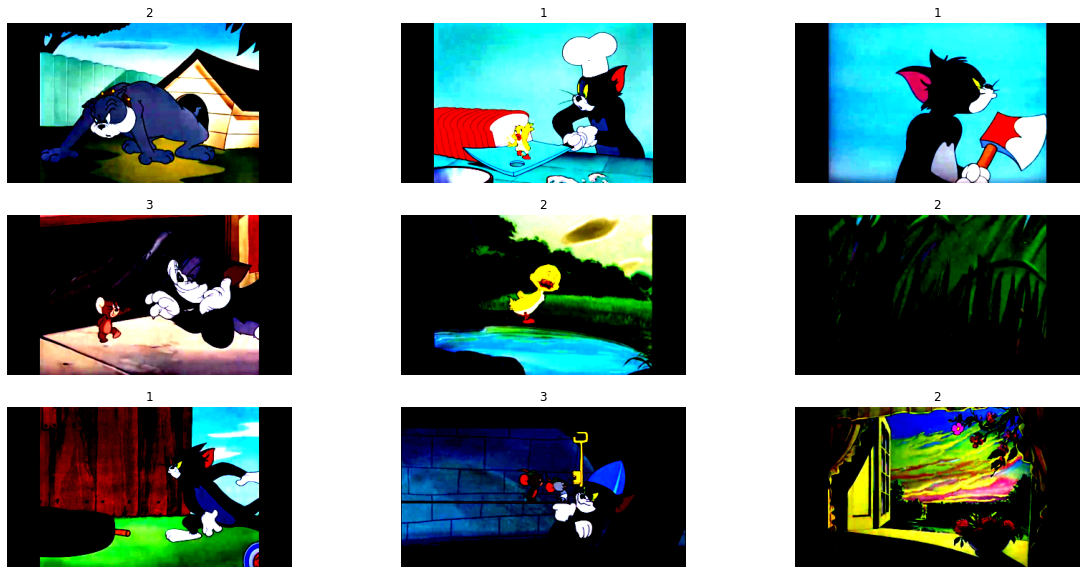

In [ ]:
def data_with_transform_plot(train_data):
    f, axes= plt.subplots(3, 3, figsize=(20,10))
    for row in range(3):
      for col in range(3):
        # random index from dataset
        rand_pic = np.random.choice(len(train_data), size=1, replace=False)
        # label
        label = train_data[rand_pic.item()][1]
        # transform tensor to picture
        pic = train_data[rand_pic.item()][0].numpy()
        pic = np.transpose(pic,(1,2,0))
        pic = np.squeeze(pic)
        #plot
        axes[row][col].imshow(pic, cmap='gray')
        axes[row][col].set_title(label)
        axes[row][col].axis('off')
    plt.show()

data_with_transform_plot(train_data)

In [ ]:
# def train_data_without_transformations_plot(train_data):
#     f, axes= plt.subplots(1, 10, figsize=(30,5))
#     for i, axis in enumerate(axes):
#         # загружаем изображения как тип ndarray (Height * Width * Channels)
#         # будьте внимательны при преобразовании dtype в np.uint8 [целое число (от 0 до 255)].
#         # в этом примере я не использую метод ToTensor() из torchvision.transforms
#         # поэтому вы можете преобразовать форму numpy ndarray в тензор в PyTorch (H, W, C) --> (C, H, W)
#         axes[i].imshow(np.squeeze(np.transpose(train_data[i][0].numpy(), (1, 2, 0))), cmap='gray') # можно было без сквиза
#         # axes[i].imshow(np.transpose(imgs[i].numpy(), (1, 2, 0)), cmap='gray')
#         axes[i].set_title(train_data[i][1])
#     plt.show()

# train_data_without_transformations_plot(train_data)

## Балансировка датасета

классы и количество элементов каждого класса

In [ ]:
classes, class_count = np.unique(train_data.dataset.targets,return_counts=True)
classes, class_count

(array([0, 1, 2, 3]), array([1240, 1930, 1528,  780]))

Видно, что классы распредеелены неравномерно, поэтому сделаем балансировку при сэмплинге

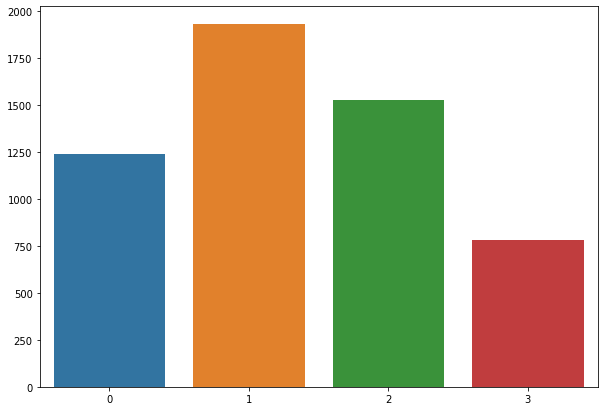

In [ ]:
plt.figure(figsize=(10,7))
sns.barplot(y = class_count, x = classes)

веса для каждого класса

In [ ]:
sample_weighths = 1/class_count
sample_weighths

array([0.00080645, 0.00051813, 0.00065445, 0.00128205])

поставим в соответствие класс : вес

In [ ]:
class_weights = {classes[i] : 1 / class_count[i] for i in range(len(classes))}
class_weights

{0: 0.0008064516129032258,
 1: 0.0005181347150259067,
 2: 0.0006544502617801048,
 3: 0.001282051282051282}

теперь каждому элементу из каждого класса назначим соответсвующий вес

In [ ]:
sample_weights = [0] * len(train_data) # список из нулей длины датасета
for i, (data, label) in enumerate(tqdm(train_data)):
    class_weight = class_weights[label]
    sample_weights[i] = class_weight

  0%|          | 0/4383 [00:00<?, ?it/s]

In [ ]:
len(sample_weights)

4383

посмотрим на веса

In [ ]:
sample_weights[:10]

[0.0005181347150259067,
 0.0006544502617801048,
 0.0006544502617801048,
 0.001282051282051282,
 0.0005181347150259067,
 0.0005181347150259067,
 0.0006544502617801048,
 0.0005181347150259067,
 0.0008064516129032258,
 0.0005181347150259067]

Посмотрю на кол-во элементов в самом большем классе

In [ ]:
# классы и количество элементов каждого класса
classes, class_count = np.unique(train_data.dataset.targets,return_counts=True)

# количество элементов в самом большем классе
max(class_count)

1930

Сделаю num_samples  - это количество которое будет сэмплировать WeightedRandomSampler равным количеество элементов в большем классе * количество классов. Таким образом я как бы сделаю oversampling для классов с меньшими количеством элементов. Если поставить num_samples равным длине датасета то WRS как бы сделает что-то среднее между undersampling для классов с большим кол-вом элементов, и oversampling для классов с меньшим кол-вом элементов.

In [ ]:
N = max(class_count) * len(class_count)
N = int(N)
print(N, type(N))

7720 <class 'int'>


WeightedRandomSampler для Dataloader, который будет брать элементы в соответствии их весам

In [ ]:
train_sampler = WeightedRandomSampler(sample_weights, num_samples = N, replacement=True)

Dataloader c WeightedRandomSampler

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle = False, pin_memory=True, num_workers=2, sampler = train_sampler)

Посмотрим на батч. Images - картинки, labels - ответы

In [ ]:
images, labels  = next(iter(train_loader))
print(images, labels)
print(images.shape,labels.shape)

tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044, -

посмотрим как даталоаэдер с помощью сэмплера будет сэмплировать классы

In [ ]:
d={}
for x_batch, y_batch in tqdm(train_loader):
  classes, class_count = np.unique(y_batch.numpy(),return_counts=True)
  for i in range(len(classes)):
    if classes[i] not in d:
      d[classes[i]]= class_count[i]
    else:
      d[classes[i]]+=class_count[i]
d

  0%|          | 0/242 [00:00<?, ?it/s]

{0: 1889, 1: 1879, 2: 1943, 3: 2009}

Видно что количество элементов каждого класса примерно одинаковое, и можно сказать что будет oversampling. Таким образом отбалансировали датасет

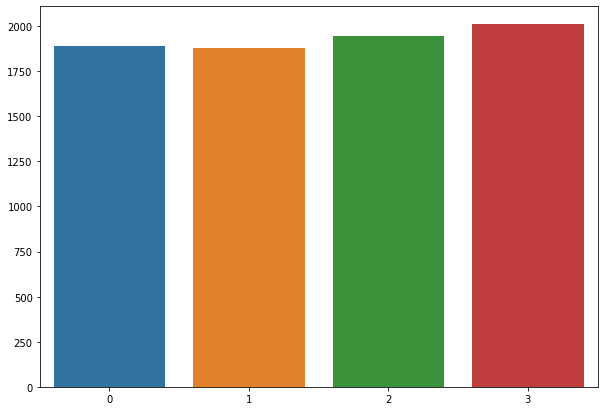

In [ ]:
plt.figure(figsize=(10,7))
sns.barplot(y = list(d.values()), x = list(d.keys()),)

# 4.Вспомогательные функции для обучения

In [ ]:
def load_and_plot_history(model_name):
  PATH_TO_MODEL = PROJECT_PATH + 'history_' + model_name + '.pt'
  checkpoint_fe = torch.load(PATH_TO_MODEL)
  plot_history(checkpoint_fe['history'])

In [ ]:
def history_saver (history, path_to_save):
  torch.save({'history': history}, 
              path_to_save)

In [ ]:
def modelsaver(epoch, model, optimizer, scheduler, history, path_to_save):
  if scheduler:
    torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler' : scheduler.state_dict()
                }, 
              path_to_save)
  else:
        torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                # 'scheduler' : scheduler
                }, 
              path_to_save)

In [ ]:
def plot_history(history):
  train_loss = []
  train_acc = []
  val_loss = []
  val_acc = []

  clear_output(wait=True)
  fig, ax = plt.subplots(1,2,figsize=(15, 7))
  fig.suptitle('loss and accuracy')

  for h in history:
    train_loss.append(h[0])
    train_acc.append(h[1])
    val_loss.append(h[2])
    val_acc.append(h[3])
    # val_acc.append(h[3].cpu().numpy()) # тк торч тензор оказался

  ax[0].set_title('Loss')
  ax[0].plot(train_loss, label = 'train_loss')
  ax[0].plot(val_loss, label = 'val_loss')
  ax[0].legend()

  ax[1].set_title('Accuracy')
  ax[1].plot(train_acc, label = 'train_acc')
  ax[1].plot(val_acc, label = 'val_acc')
  ax[1].legend()

  plt.show()

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer, is_inception):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in tqdm(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        if not is_inception:
          outputs = model(inputs)
          loss = criterion(outputs, labels)
        else:
          outputs, aux_outputs = model(inputs)
          loss1 = criterion(outputs, labels)
          loss2 = criterion(aux_outputs, labels)
          loss = loss1 + 0.4*loss2

      # backward + optimize
        loss.backward()
        optimizer.step()
        
      # predict
        preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
  
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data

    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in tqdm(val_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)

    val_loss = running_loss / processed_size
    # val_acc = running_corrects.double() / processed_size
    val_acc = running_corrects.cpu().numpy() / processed_size # в следующий раз сделать так  чтобы не сохранялся тензор

    return val_loss, val_acc

In [ ]:
def train(train_data, val_data, model, optimizer, criterion, epochs, batch_size,
          path_to_save_model, path_to_save_history, sampler = None, scheduler = None,
          is_inception = False):
  
    start_time = time.time()
    
  #train loader
    if sampler:
      train_loader = DataLoader(train_data, batch_size=batch_size, sampler=sampler, pin_memory=True, num_workers=2)
    else:
      train_loader = DataLoader(train_data, batch_size=batch_size, shuffle = True, pin_memory=True, num_workers=2)

  # val loader
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle = True, pin_memory=True, num_workers=2)

    history = []

    # lowest_loss = float('inf')
    highest_acc = 0

    with tqdm(desc="epoch", total=epochs) as pbar_outer:

        for epoch in range(epochs):
          #train
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, optimizer, is_inception)
            print(f'train_loss = {train_loss}, train_acc = {train_acc}')

          #test
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            print(f'val_loss = {val_loss}, val_acc = {val_acc}')

          # save losses and accuracies
            history.append((train_loss, train_acc, val_loss, val_acc))

          #history saver
            history_saver(history, path_to_save_history)
            
          #сохраню модель
            if val_acc > highest_acc:
              modelsaver(epoch, model, optimizer, scheduler, history, path_to_save_model)
              highest_acc = val_acc
              print(f'new model was saved with val_acc = highest_acc = {highest_acc}')

          #lr scheduler
            if scheduler:
              scheduler.step()

          # вывести результаты эпохи
            print(f'epoch = {epoch}, train_loss = {train_loss}, train_acc = {train_acc}, val_loss = {val_loss}, val_acc = {val_acc}')

          # draw plots and pictures durin epochs
            plot_history(history)

          # обновить бар
            pbar_outer.update(1)

    # время на скрипт
    train_time = time.time() - start_time
    print(f'train_time = {train_time}')

    return history, train_time

In [ ]:
def test(val_data, model, criterion, batch_size):
  #val loader
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle = True, pin_memory=True, num_workers=2)

  #test
    val_loss, val_acc = eval_epoch(model, val_loader, criterion)
    print(f'val_loss = {val_loss}, val_acc = {val_acc}')

# 5.Подготовка модели Alexnet

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# инициализация модели alexnet претренированной
model = models.alexnet(weights = 'IMAGENET1K_V1')

In [ ]:
# параметры модели
model.parameters

<bound method Module.parameters of AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=92

In [ ]:
# # убираем обновление градиентов
# for param in model.parameters():
#     param.requires_grad = False

In [ ]:
# количество классов в датасете
num_classes = len(train_data.dataset.classes)
num_classes

4

In [ ]:
# последний слой - классификатор
model.classifier

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [ ]:
# количество признаков на вход новому последнему линейному слою
num_ftrs = model.classifier[6].in_features
num_ftrs

4096

In [ ]:
# заменяем последний слой новым линейным с нужным количеством выходных классов
model.classifier[6] = nn.Linear(num_ftrs, num_classes)

In [ ]:
# получившийся классификатор
model.classifier

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=4, bias=True)
)

Видно что обучаемые параметры это вес и смещение последнего линейного слоя

In [ ]:
# перенос финальной модели на устройство
model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
# тест форварда модели
# x = torch.rand(4, 3, 224, 224)
# out = model.forward(x)

## Обучение

In [ ]:
torch.cuda.empty_cache()
gc.collect()

55266

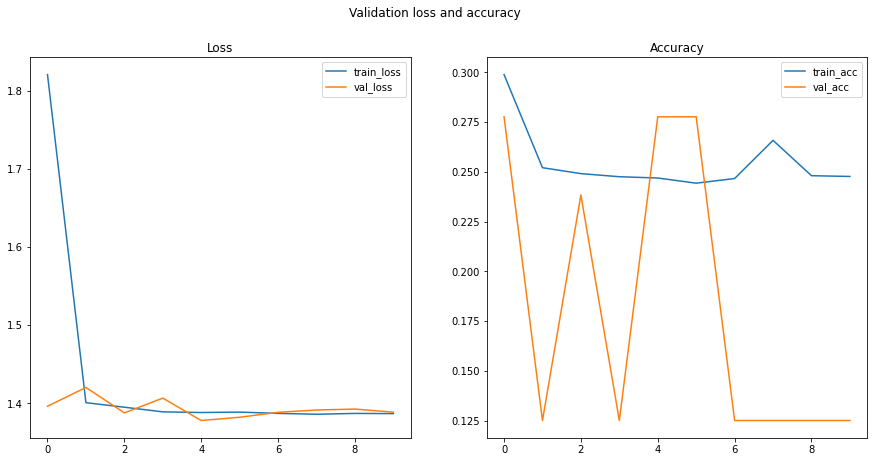

train_time = 1106.1522331237793


In [ ]:
# имя для сохраненяемой модели
model_name = 'model_alexnet_ft'

# куда сохраняем модель
PATH_TO_SAVE_MODEL = PROJECT_PATH + model_name + '.pt'

# куда сохр историю
PATH_TO_SAVE_HISTORY = PROJECT_PATH + 'history_' + model_name + '.pt'

# лосс
criterion = nn.CrossEntropyLoss()

# optimizer
# обучаем все слои модели тк fine tuning - > model.parameters()
optimizer = torch.optim.Adam(model.parameters(), amsgrad = True, weight_decay = 1e-5, lr = 1e-3)

# scheduler
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma=0.1)

# размер батча
batch_size = 800

# количество эпох
epochs = 10

# обучение
history, train_time_alexnet_ft = train(train_data, val_data, model=model, optimizer = optimizer,
                criterion = criterion, epochs=epochs, batch_size=batch_size, 
                path_to_save_model = PATH_TO_SAVE_MODEL, path_to_save_history = PATH_TO_SAVE_HISTORY,
                sampler = train_sampler, scheduler = scheduler)

train_time_alexnet_ft = 1106.1522331237793
train_time_alexnet_fe = 1086.8976394875695

In [ ]:
train_time_alexnet_fe = 1086.8976394875695
train_time_alexnet_ft = 1106.1522331237793

## Загрузка истории

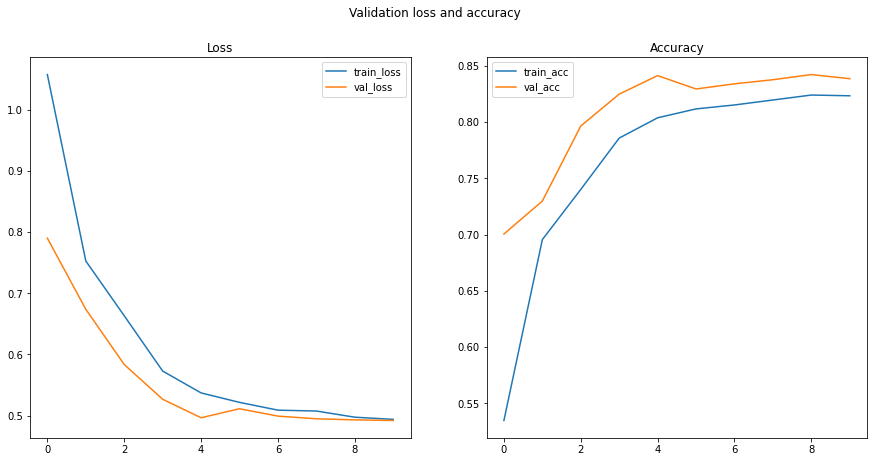

In [ ]:
load_and_plot_history('model_alexnet_fe')

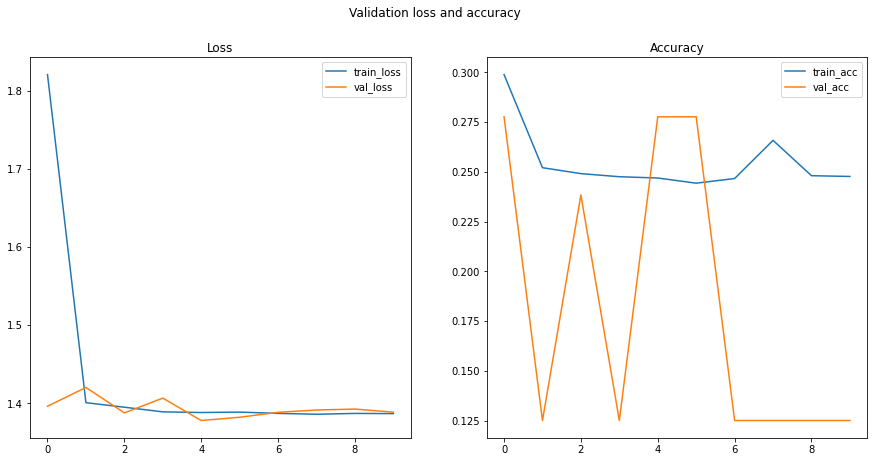

In [ ]:
load_and_plot_history('model_alexnet_ft')

# 6.Подготовка модели Convnext

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# инициализация модели alexnet претренированной
model = models.convnext_base(weights = 'IMAGENET1K_V1')

Downloading: "https://download.pytorch.org/models/convnext_base-6075fbad.pth" to /root/.cache/torch/hub/checkpoints/convnext_base-6075fbad.pth


  0%|          | 0.00/338M [00:00<?, ?B/s]

In [ ]:
# параметры модели
model.parameters

<bound method Module.parameters of ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=128, out_features=512, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=512, out_features=128, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_

In [ ]:
# убираем обновление градиентов
for param in model.parameters():
    param.requires_grad = False

In [ ]:
# количество классов в датасете
num_classes = len(train_data.dataset.classes)
num_classes

4

In [ ]:
# последний слой - классификатор
model.classifier

Sequential(
  (0): LayerNorm2d((1024,), eps=1e-06, elementwise_affine=True)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=1024, out_features=1000, bias=True)
)

In [ ]:
# количество признаков на вход новому последнему линейному слою
num_ftrs = model.classifier[2].in_features
num_ftrs

1024

In [ ]:
# заменяем последний слой новым линейным с нужным количеством выходных классов
model.classifier[2] = nn.Linear(num_ftrs, num_classes)

In [ ]:
# получившийся классификатор
model.classifier

Sequential(
  (0): LayerNorm2d((1024,), eps=1e-06, elementwise_affine=True)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=1024, out_features=4, bias=True)
)

Видно что обучаемые параметры это вес и смещение последнего линейного слоя

In [ ]:
# перенос финальной модели на устройство
model.to(device)

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=128, out_features=512, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=512, out_features=128, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (3): Linear(

In [ ]:
# тест форварда модели
# x = torch.rand(4, 3, 224, 224)
# out = model.forward(x)

## Обучение

In [ ]:
!nvidia-smi

Mon Jan  9 12:41:22 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P0    29W /  70W |    922MiB / 15109MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
torch.cuda.empty_cache()
gc.collect()

46

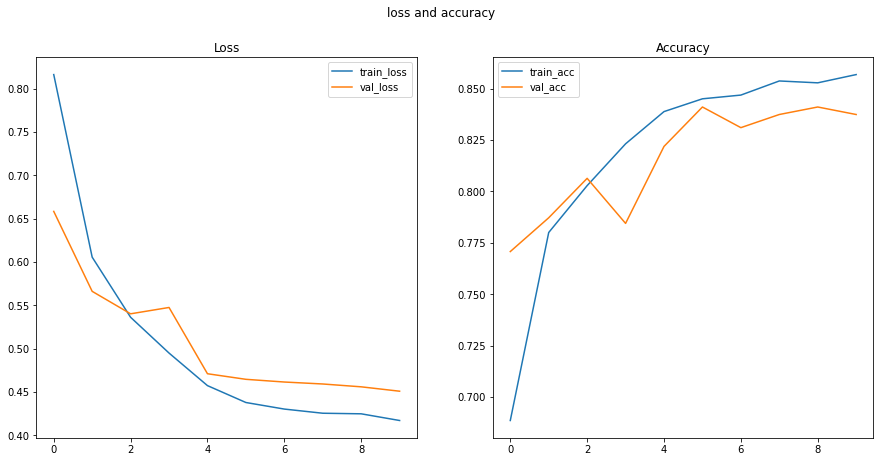

train_time = 2214.3288333415985


In [ ]:
# имя для сохраненяемой модели
model_name = 'model_convnext_base_ft_new'

# куда сохраняем модель
PATH_TO_SAVE_MODEL = PROJECT_PATH + model_name + '.pt'

# куда сохр историю
PATH_TO_SAVE_HISTORY = PROJECT_PATH + 'history_' + model_name + '.pt'

# лосс
criterion = nn.CrossEntropyLoss()

# optimizer
# model.classifier[2].parameters() - feature extraction, model.parameters() -> fine tuning
optimizer = torch.optim.Adam(model.classifier[2].parameters(), amsgrad = True, weight_decay = 1e-5, lr = 1e-3)

# scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma=0.1)

# размер батча
batch_size = 10

# количество эпох
epochs = 10

# обучение
history, train_time_convnext_base_ft_new = train(train_data, val_data, model=model, optimizer = optimizer,
                criterion = criterion, epochs=epochs, batch_size=batch_size, 
                path_to_save_model = PATH_TO_SAVE_MODEL, path_to_save_history = PATH_TO_SAVE_HISTORY,
                sampler = train_sampler, scheduler = scheduler)

train_time_convnext_base_fe_new = 2214.3288333415985
train_time_convnext_base_ft = 10013.9873250963242

In [ ]:
train_time_convnext_base_fe_new = 2214.3288333415985
train_time_convnext_base_ft = 10013.9873250963242

train_time_convnext_base_ft 1.40 на 6 эпох

## Загрузка истории

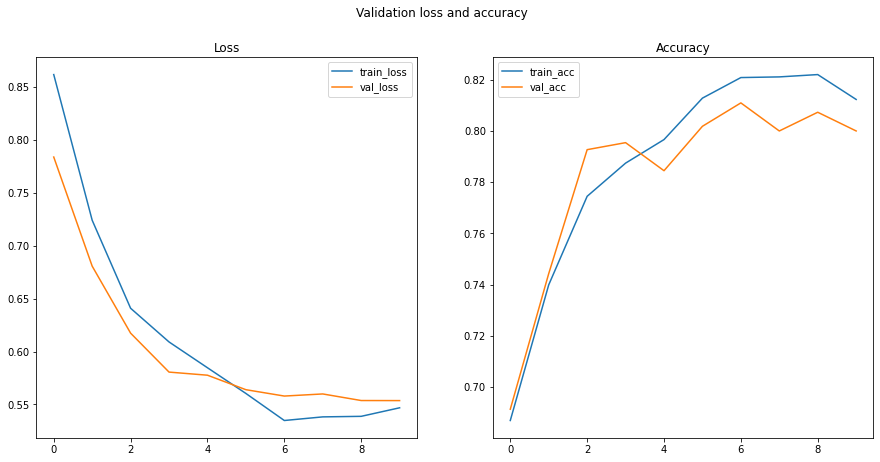

In [ ]:
load_and_plot_history('model_convnext_base_fe')

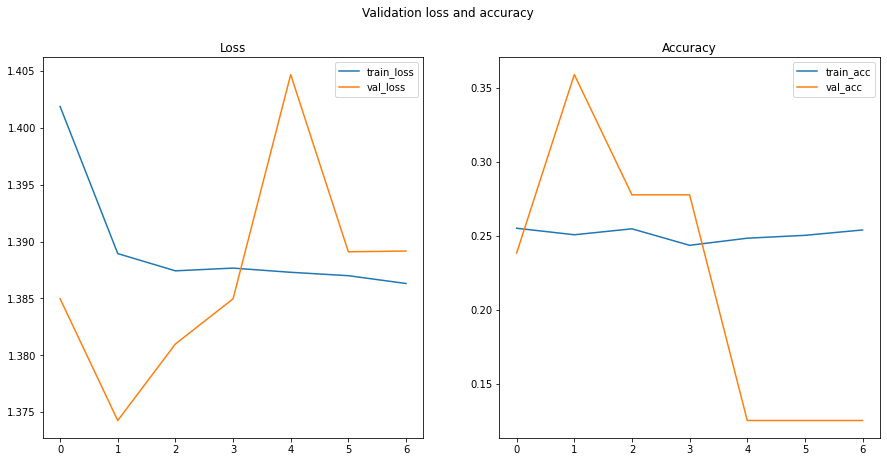

In [ ]:
load_and_plot_history('model_convnext_base_ft')

# 7.Подготовка модели VGG11_bn

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# инициализация модели alexnet претренированной
model = models.vgg11_bn(weights = 'IMAGENET1K_V1')

In [ ]:
# параметры модели
model.parameters

<bound method Module.parameters of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(i

In [ ]:
# # убираем обновление градиентов
# for param in model.parameters():
#     param.requires_grad = False

In [ ]:
# количество классов в датасете
num_classes = len(train_data.dataset.classes)
num_classes

4

In [ ]:
# последний слой - классификатор
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [ ]:
# количество признаков на вход новому последнему линейному слою
num_ftrs = model.classifier[6].in_features
num_ftrs

4096

In [ ]:
# заменяем последний слой новым линейным с нужным количеством выходных классов
model.classifier[6] = nn.Linear(num_ftrs, num_classes)

In [ ]:
# получившийся классификатор
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=4, bias=True)
)

Видно что обучаемые параметры это вес и смещение последнего линейного слоя

In [ ]:
# перенос финальной модели на устройство
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [ ]:
# тест форварда модели
# x = torch.rand(4, 3, 224, 224)
# out = model.forward(x)

## Обучение

In [ ]:
!nvidia-smi

Sun Jan  8 09:32:15 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    26W /  70W |  14208MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
torch.cuda.empty_cache()
gc.collect()

124

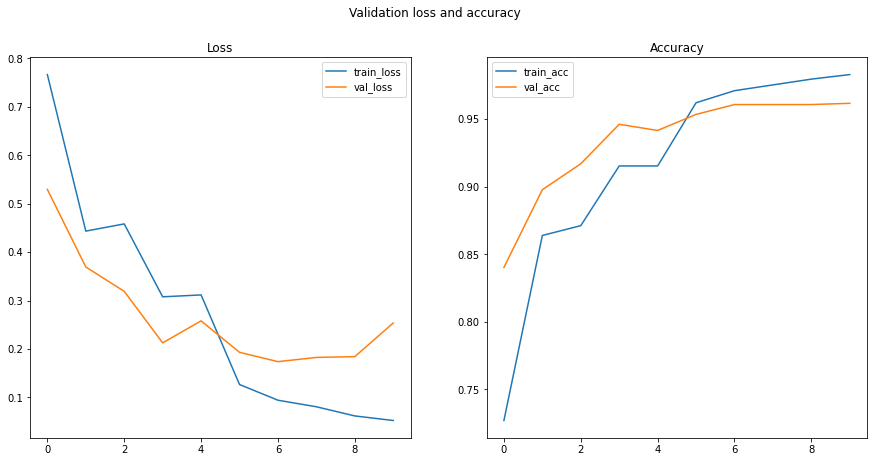

train_time = 1934.7628409862518


In [ ]:
# имя для сохраненяемой модели
model_name = 'model_vgg11_bn_ft'

# куда сохраняем модель
PATH_TO_SAVE_MODEL = PROJECT_PATH + model_name + '.pt'

# куда сохр историю
PATH_TO_SAVE_HISTORY = PROJECT_PATH + 'history_' + model_name + '.pt'

# лосс
criterion = nn.CrossEntropyLoss()

# optimizer
# model.classifier[2].parameters() - feature extraction, model.parameters() -> fine tuning
optimizer = torch.optim.Adam(model.parameters(), amsgrad = True, weight_decay = 1e-5, lr = 1e-3)

# scheduler
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma=0.1)

# размер батча
batch_size = 10

# количество эпох
epochs = 10

# обучение
history, train_time_vgg11_bn_ft = train(train_data, val_data, model=model, optimizer = optimizer,
                criterion = criterion, epochs=epochs, batch_size=batch_size, 
                path_to_save_model = PATH_TO_SAVE_MODEL, path_to_save_history = PATH_TO_SAVE_HISTORY,
                sampler = train_sampler, scheduler = scheduler)

train_time_vgg11_bn_fe = 772.2326216697693 train_time_vgg11_bn_ft = 1934.7628409862518

In [ ]:
train_time_vgg11_bn_fe = 772.2326216697693
train_time_vgg11_bn_ft = 1934.7628409862518

## Загрузка истории

In [ ]:
load_and_plot_history('model_vgg11_bn_fe')

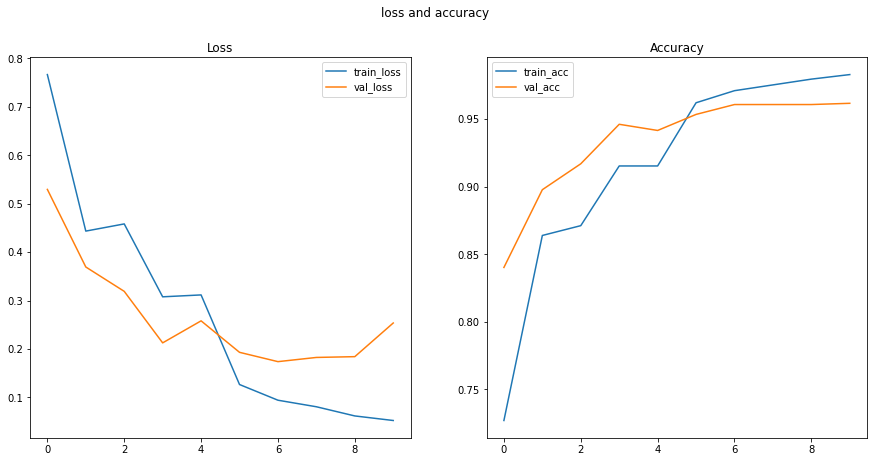

In [ ]:
load_and_plot_history('model_vgg11_bn_ft')

# 8.Подготовка модели Resnet152

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

These weights improve upon the results of the original paper by using TorchVision’s new [training recipe](https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/).

In [ ]:
# инициализация модели alexnet претренированной
model = models.resnet152(weights = 'IMAGENET1K_V2')

In [ ]:
# параметры модели
model.parameters

<bound method Module.parameters of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 2

In [ ]:
# # убираем обновление градиентов
# for param in model.parameters():
#     param.requires_grad = False

In [ ]:
# количество классов в датасете
num_classes = len(train_data.dataset.classes)
num_classes

4

In [ ]:
# последний слой - классификатор
model.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [ ]:
# количество признаков на вход новому последнему линейному слою
num_ftrs = model.fc.in_features
num_ftrs

2048

In [ ]:
# заменяем последний слой новым линейным с нужным количеством выходных классов
model.fc = nn.Linear(num_ftrs, num_classes)

In [ ]:
# получившийся классификатор
model.fc

Linear(in_features=2048, out_features=4, bias=True)

Видно что обучаемые параметры это вес и смещение последнего линейного слоя

In [ ]:
# перенос финальной модели на устройство
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# тест форварда модели
# x = torch.rand(4, 3, 224, 224)
# out = model.forward(x)

## Обучение

In [ ]:
!nvidia-smi

Sun Jan  8 11:00:54 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    31W /  70W |  14396MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
torch.cuda.empty_cache()
gc.collect()

133

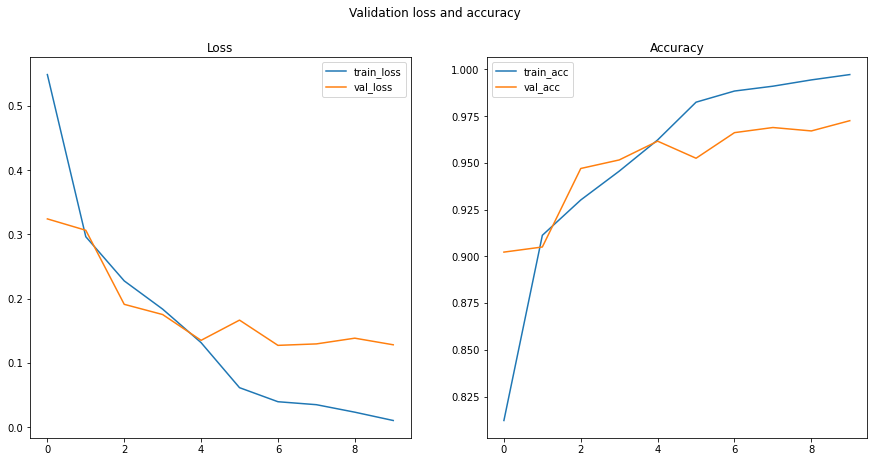

train_time = 3814.0271854400635


In [ ]:
# имя для сохраненяемой модели
model_name = 'model_resnet152_ft'

# куда сохраняем модель
PATH_TO_SAVE_MODEL = PROJECT_PATH + model_name + '.pt'

# куда сохр историю
PATH_TO_SAVE_HISTORY = PROJECT_PATH + 'history_' + model_name + '.pt'

# лосс
criterion = nn.CrossEntropyLoss()

# optimizer
# model.classifier[2].parameters() - feature extraction, model.parameters() -> fine tuning
optimizer = torch.optim.Adam(model.parameters(), amsgrad = True, weight_decay = 1e-5, lr = 1e-3)

# scheduler
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma=0.1)

# размер батча
batch_size = 10

# количество эпох
epochs = 10

# обучение
history, train_time_resnet152_ft = train(train_data, val_data, model=model, optimizer = optimizer,
                criterion = criterion, epochs=epochs, batch_size=batch_size, 
                path_to_save_model = PATH_TO_SAVE_MODEL, path_to_save_history = PATH_TO_SAVE_HISTORY,
                sampler = train_sampler, scheduler = scheduler)

train_time_resnet152_fe = 1293.1927645206451
train_time_resnet152_ft = 3814.0271854400635

In [ ]:
train_time_resnet152_fe = 1293.1927645206451
train_time_resnet152_ft = 3814.0271854400635

## Загрузка истории

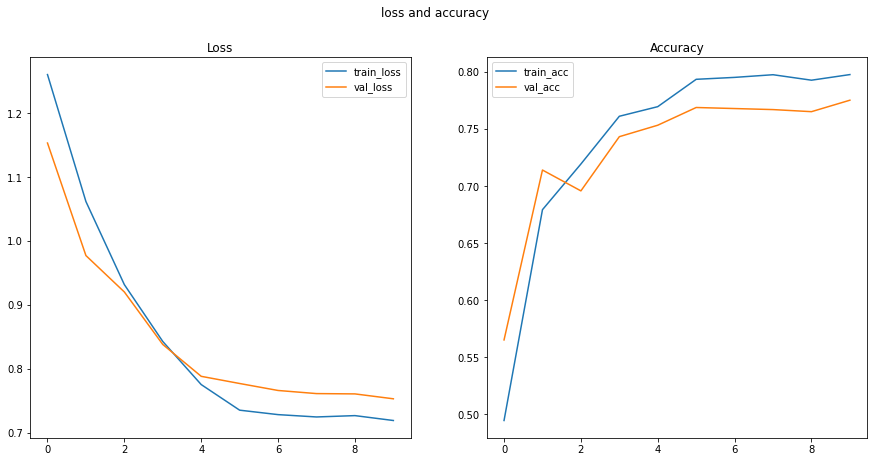

In [ ]:
load_and_plot_history('model_resnet152_fe')

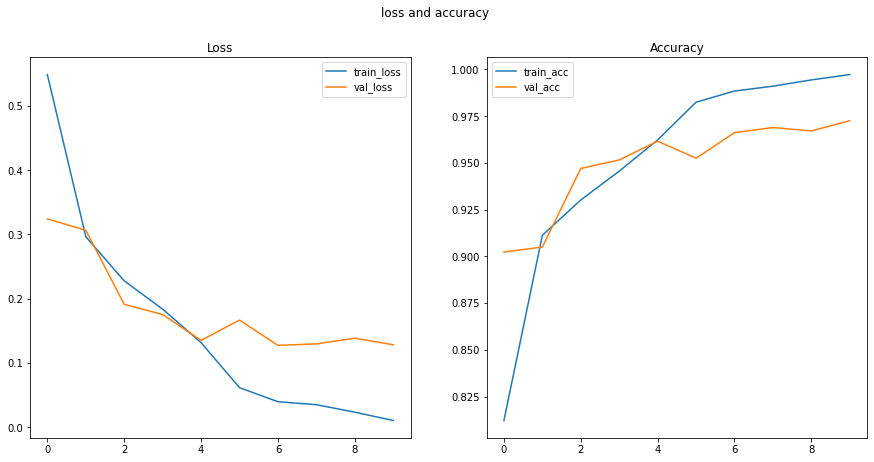

In [ ]:
load_and_plot_history('model_resnet152_ft')

# 9.Подготовка модели Densenet161

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# инициализация модели alexnet претренированной
model = models.densenet161(weights = 'IMAGENET1K_V1')

In [ ]:
# параметры модели
model.parameters

<bound method Module.parameters of DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, tra

In [ ]:
# # убираем обновление градиентов
# for param in model.parameters():
#     param.requires_grad = False

In [ ]:
# количество классов в датасете
num_classes = len(train_data.dataset.classes)
num_classes

4

In [ ]:
# последний слой - классификатор
model.classifier

Linear(in_features=2208, out_features=1000, bias=True)

In [ ]:
# количество признаков на вход новому последнему линейному слою
num_ftrs = model.classifier.in_features
num_ftrs

2208

In [ ]:
# заменяем последний слой новым линейным с нужным количеством выходных классов
model.classifier = nn.Linear(num_ftrs, num_classes)

In [ ]:
# получившийся классификатор
model.classifier

Linear(in_features=2208, out_features=4, bias=True)

Видно что обучаемые параметры это вес и смещение последнего линейного слоя

In [ ]:
# перенос финальной модели на устройство
model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [ ]:
# тест форварда модели
# x = torch.rand(4, 3, 224, 224)
# out = model.forward(x)

## Обучение

In [ ]:
!nvidia-smi

Sun Jan  8 12:40:22 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    29W /  70W |  11372MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
torch.cuda.empty_cache()
gc.collect()

34

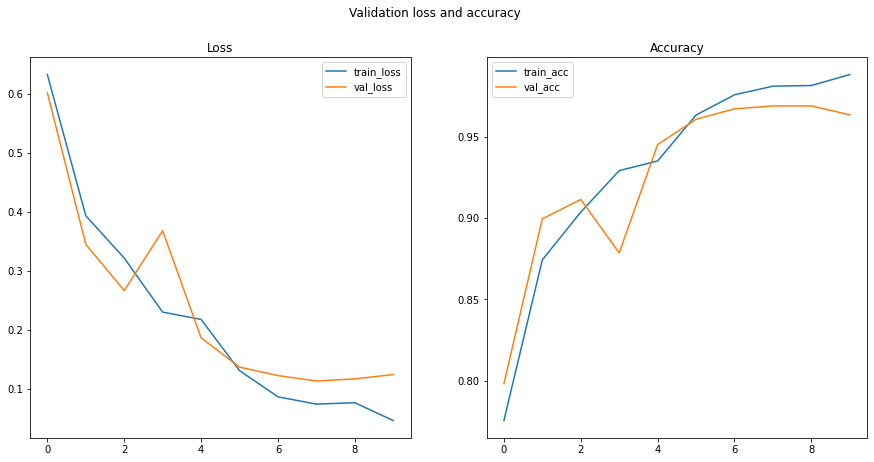

train_time = 3522.60404586792


In [ ]:
# имя для сохраненяемой модели
model_name = 'model_densenet161_ft'

# куда сохраняем модель
PATH_TO_SAVE_MODEL = PROJECT_PATH + model_name + '.pt'

# куда сохр историю
PATH_TO_SAVE_HISTORY = PROJECT_PATH + 'history_' + model_name + '.pt'

# лосс
criterion = nn.CrossEntropyLoss()

# optimizer
# model.classifier[2].parameters() - feature extraction, model.parameters() -> fine tuning
optimizer = torch.optim.Adam(model.parameters(), amsgrad = True, weight_decay = 1e-5, lr = 1e-3)

# scheduler
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma=0.1)

# размер батча
batch_size = 10

# количество эпох
epochs = 10

# обучение
history, train_time_densenet161_ft = train(train_data, val_data, model=model, optimizer = optimizer,
                criterion = criterion, epochs=epochs, batch_size=batch_size, 
                path_to_save_model = PATH_TO_SAVE_MODEL, path_to_save_history = PATH_TO_SAVE_HISTORY,
                sampler = train_sampler, scheduler = scheduler)

train_time_densenet161_fe = 1227.209811925888
train_time_densenet161_ft = 3522.60404586792

In [ ]:
train_time_densenet161_fe = 1227.209811925888
train_time_densenet161_ft = 3522.60404586792

## Загрузка истории

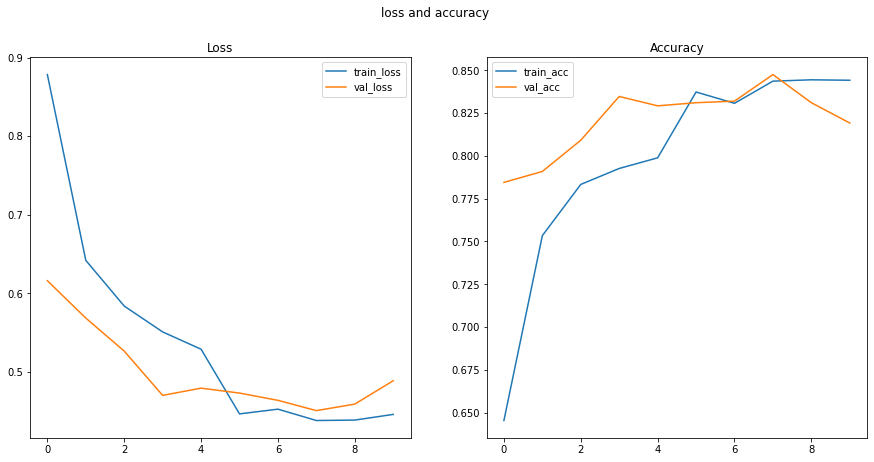

In [ ]:
load_and_plot_history('model_densenet161_fe')

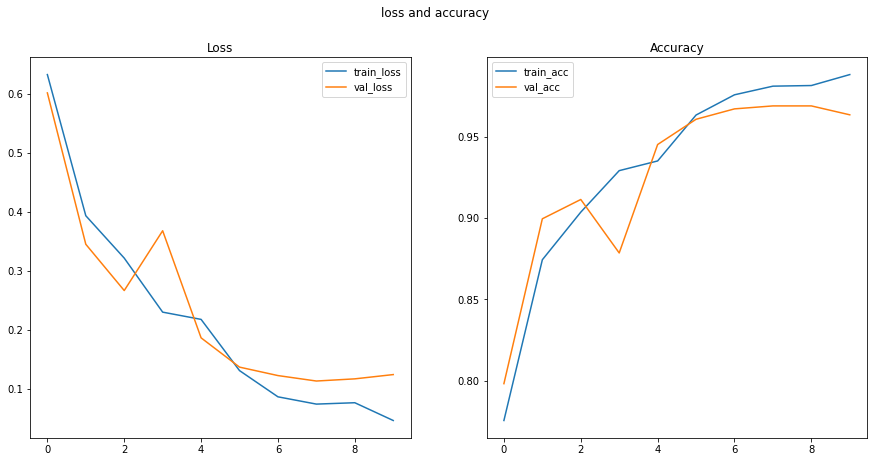

In [ ]:
load_and_plot_history('model_densenet161_ft')

# 10.Подготовка модели InceptionV3

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# инициализация модели alexnet претренированной
model = models.inception_v3(weights = 'IMAGENET1K_V1')

In [ ]:
# параметры модели
model.parameters

<bound method Module.parameters of Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2

In [ ]:
# # убираем обновление градиентов
# for param in model.parameters():
#     param.requires_grad = False

In [ ]:
# количество классов в датасете
num_classes = len(train_data.dataset.classes)
num_classes

4

Тут надо менять 2 слоя - в Auxlogits и  fc

In [ ]:
model.AuxLogits

InceptionAux(
  (conv0): BasicConv2d(
    (conv): Conv2d(768, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv1): BasicConv2d(
    (conv): Conv2d(128, 768, kernel_size=(5, 5), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(768, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=768, out_features=1000, bias=True)
)

In [ ]:
num_ftrs = model.AuxLogits.fc.in_features
num_ftrs

768

In [ ]:
model.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)

In [ ]:
model.AuxLogits

InceptionAux(
  (conv0): BasicConv2d(
    (conv): Conv2d(768, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv1): BasicConv2d(
    (conv): Conv2d(128, 768, kernel_size=(5, 5), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(768, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=768, out_features=4, bias=True)
)

In [ ]:
# последний слой - классификатор
model.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [ ]:
# количество признаков на вход новому последнему линейному слою
num_ftrs = model.fc.in_features
num_ftrs

2048

In [ ]:
# заменяем последний слой новым линейным с нужным количеством выходных классов
model.fc = nn.Linear(num_ftrs, num_classes)

In [ ]:
# получившийся классификатор
model.fc

Linear(in_features=2048, out_features=4, bias=True)

Видно что обучаемые параметры это вес и смещение последнего линейного слоя

In [ ]:
# перенос финальной модели на устройство
model.to(device)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [ ]:
# тест форварда модели
# x = torch.rand(4, 3, 224, 224)
# out = model.forward(x)

## Обучение

In [ ]:
!nvidia-smi

Sun Jan  8 15:24:58 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    29W /  70W |  11340MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
torch.cuda.empty_cache()
gc.collect()

55980

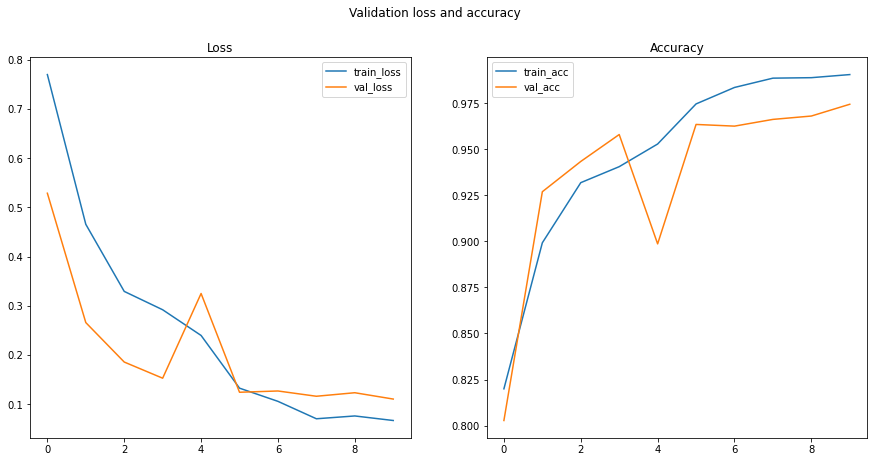

train_time = 2300.269156932831


In [ ]:
# имя для сохраненяемой модели
model_name = 'model_inception_v3_ft'

# куда сохраняем модель
PATH_TO_SAVE_MODEL = PROJECT_PATH + model_name + '.pt'

# куда сохр историю
PATH_TO_SAVE_HISTORY = PROJECT_PATH + 'history_' + model_name + '.pt'

# лосс
criterion = nn.CrossEntropyLoss()

# optimizer
# list(model.AuxLogits.fc.parameters()) + list(model.fc.parameters()) - feature extraction, model.parameters() -> fine tuning
optimizer = torch.optim.Adam(model.parameters(), amsgrad = True, weight_decay = 1e-5, lr = 1e-3)

# scheduler
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma=0.1)

# размер батча
batch_size = 10

# количество эпох
epochs = 10

# обучение
history, train_time_inception_v3_ft = train(train_data, val_data, model=model, optimizer = optimizer,
                criterion = criterion, epochs=epochs, batch_size=batch_size, 
                path_to_save_model = PATH_TO_SAVE_MODEL, path_to_save_history = PATH_TO_SAVE_HISTORY,
                sampler = train_sampler, scheduler = scheduler, is_inception = True)

train_time_inception_v3_fe = 842.6096646785736
train_time_inception_v3_ft = 2300.269156932831

In [ ]:
train_time_inception_v3_fe = 842.6096646785736
train_time_inception_v3_ft = 2300.269156932831

## Загрузка модели для дообучения

In [ ]:
torch.cuda.empty_cache()
gc.collect()

57116

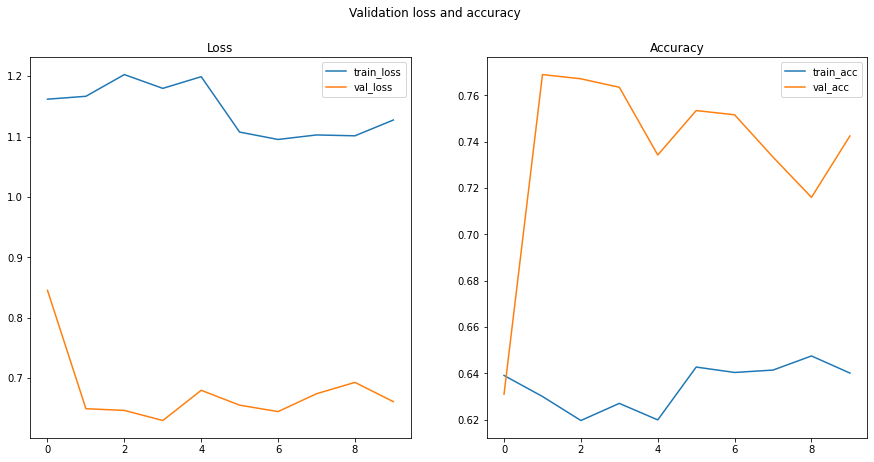

train_time = 831.9818093776703


In [ ]:
# имя для сохраненяемой модели
model_name = 'model_inception_v3_fe_+10ep'

# куда сохраняем модель
PATH_TO_SAVE_MODEL = PROJECT_PATH + model_name + '.pt'

# куда сохр историю
PATH_TO_SAVE_HISTORY = PROJECT_PATH + 'history_' + model_name + '.pt'

# лосс
criterion = nn.CrossEntropyLoss()

# optimizer
# model.classifier[2].parameters() - feature extraction, model.parameters() -> fine tuning
optimizer = torch.optim.Adam(list(model.AuxLogits.fc.parameters()) + list(model.fc.parameters()), amsgrad = True, weight_decay = 1e-5, lr = 1e-3)

# scheduler
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma=0.1)

# загружаем из чекпоинты модели по пути
checkpoint = torch.load(PATH_TO_SAVE_MODEL)

# реинициализирую модель, оптимизатор, планировщик
model.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])
scheduler.load_state_dict(checkpoint['scheduler'])

# размер батча
batch_size = 10

# количество эпох
epochs = 10

# обучение
history, train_time_inception_v3_fe = train(train_data, val_data, model=model, optimizer = optimizer,
                criterion = criterion, epochs=epochs, batch_size=batch_size, 
                path_to_save_model = PATH_TO_SAVE_MODEL, path_to_save_history = PATH_TO_SAVE_HISTORY,
                sampler = train_sampler, scheduler = scheduler, is_inception = True)

In [ ]:
train_time_inception_v3_fe_+10ep = 831.9818093776703

## Загрузка истории

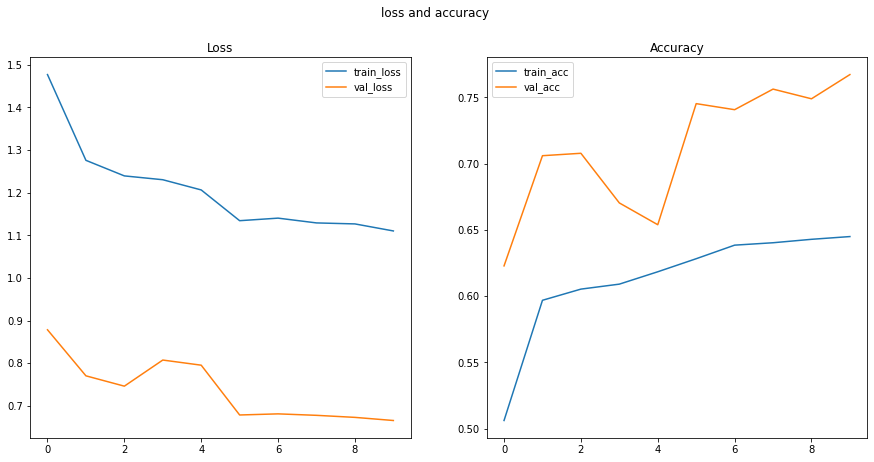

In [ ]:
load_and_plot_history('model_inception_v3_fe')

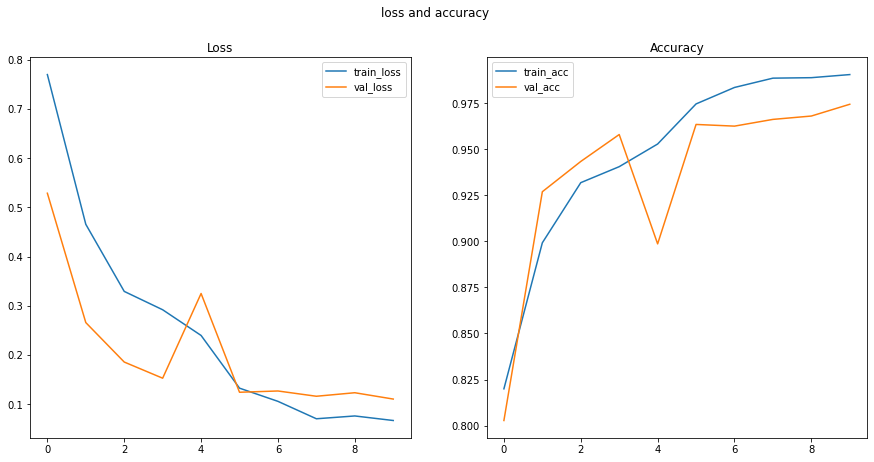

In [ ]:
load_and_plot_history('model_inception_v3_ft')

# 11.Подготовка модели mobilenet_v3_large

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

These weights improve upon the results of the original paper by using TorchVision’s new [training recipe](https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/).

In [ ]:
# инициализация модели alexnet претренированной
model = models.mobilenet_v3_large(weights = 'IMAGENET1K_V2')

In [ ]:
# параметры модели
model.parameters

<bound method Module.parameters of MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, ke

In [ ]:
# # убираем обновление градиентов
# for param in model.parameters():
#     param.requires_grad = False

In [ ]:
# количество классов в датасете
num_classes = len(train_data.dataset.classes)
num_classes

4

In [ ]:
# последний слой - классификатор
model.classifier

Sequential(
  (0): Linear(in_features=960, out_features=1280, bias=True)
  (1): Hardswish()
  (2): Dropout(p=0.2, inplace=True)
  (3): Linear(in_features=1280, out_features=1000, bias=True)
)

In [ ]:
# количество признаков на вход новому последнему линейному слою
num_ftrs = model.classifier[3].in_features
num_ftrs

1280

In [ ]:
# заменяем последний слой новым линейным с нужным количеством выходных классов
model.classifier[3] = nn.Linear(num_ftrs, num_classes)

In [ ]:
# получившийся классификатор
model.classifier

Sequential(
  (0): Linear(in_features=960, out_features=1280, bias=True)
  (1): Hardswish()
  (2): Dropout(p=0.2, inplace=True)
  (3): Linear(in_features=1280, out_features=4, bias=True)
)

Видно что обучаемые параметры это вес и смещение последнего линейного слоя

In [ ]:
# перенос финальной модели на устройство
model.to(device)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [ ]:
# тест форварда модели
# x = torch.rand(4, 3, 224, 224)
# out = model.forward(x)

## Обучение

In [ ]:
!nvidia-smi

Sun Jan  8 16:34:42 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P0    29W /  70W |  11492MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
torch.cuda.empty_cache()
gc.collect()

55895

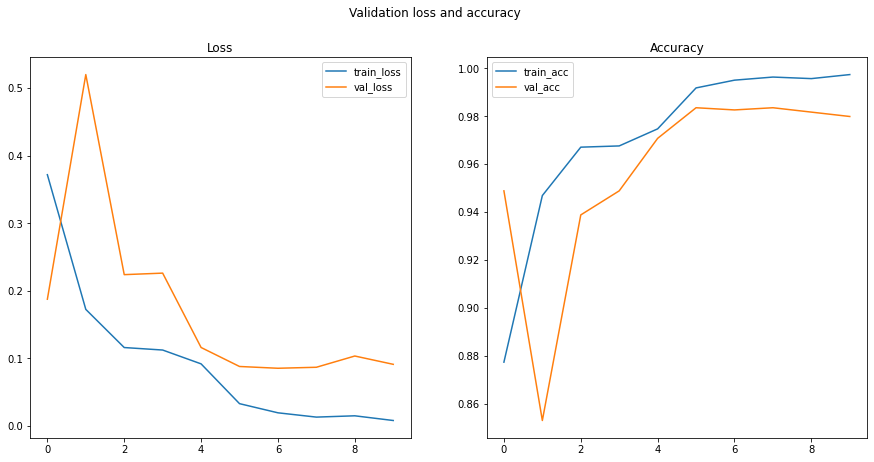

train_time = 933.6277282238007


In [ ]:
# имя для сохраненяемой модели
model_name = 'model_mobilenet_v3_large_ft'

# куда сохраняем модель
PATH_TO_SAVE_MODEL = PROJECT_PATH + model_name + '.pt'

# куда сохр историю
PATH_TO_SAVE_HISTORY = PROJECT_PATH + 'history_' + model_name + '.pt'

# лосс
criterion = nn.CrossEntropyLoss()

# optimizer
# model.classifier[3].parameters(), - feature extraction, model.parameters() -> fine tuning
optimizer = torch.optim.Adam(model.parameters(), amsgrad = True, weight_decay = 1e-5, lr = 1e-3)

# scheduler
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma=0.1)

# размер батча
batch_size = 10

# количество эпох
epochs = 10

# обучение
history, train_time_mobilenet_v3_large_fe = train(train_data, val_data, model=model, optimizer = optimizer,
                criterion = criterion, epochs=epochs, batch_size=batch_size, 
                path_to_save_model = PATH_TO_SAVE_MODEL, path_to_save_history = PATH_TO_SAVE_HISTORY,
                sampler = train_sampler, scheduler = scheduler, is_inception = False)

train_time_mobilenet_v3_large_fe = 870.0678339004517
train_time_mobilenet_v3_large_ft = 933.6277282238007

In [ ]:
train_time_mobilenet_v3_large_fe = 870.0678339004517
train_time_mobilenet_v3_large_ft = 933.6277282238007

## Загрузка истории

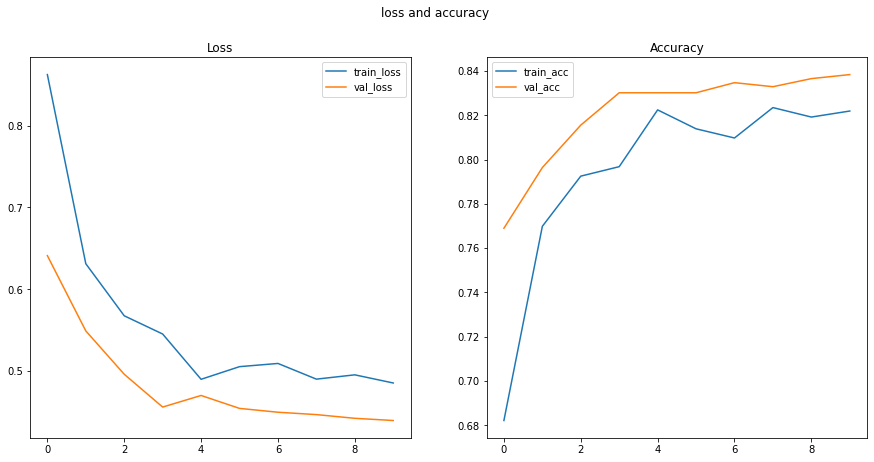

In [ ]:
load_and_plot_history('model_mobilenet_v3_large_fe')

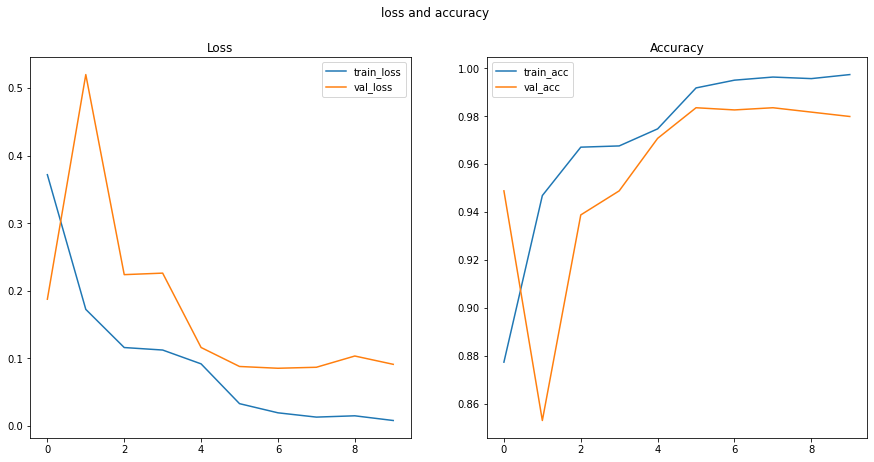

In [ ]:
load_and_plot_history('model_mobilenet_v3_large_ft')

# 12.Подготовка модели efficientnet_v2_m

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

These weights improve upon the results of the original paper by using TorchVision’s new [training recipe](https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/).

In [ ]:
# инициализация модели alexnet претренированной
model = models.efficientnet_v2_m(weights = 'IMAGENET1K_V1')

In [ ]:
# параметры модели
model.parameters

<bound method Module.parameters of EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine

In [ ]:
# # убираем обновление градиентов
# for param in model.parameters():
#     param.requires_grad = False

In [ ]:
# количество классов в датасете
num_classes = len(train_data.dataset.classes)
num_classes

4

In [ ]:
# последний слой - классификатор
model.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [ ]:
# количество признаков на вход новому последнему линейному слою
num_ftrs = model.classifier[1].in_features
num_ftrs

1280

In [ ]:
# заменяем последний слой новым линейным с нужным количеством выходных классов
model.classifier[1] = nn.Linear(num_ftrs, num_classes)

In [ ]:
# получившийся классификатор
model.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1280, out_features=4, bias=True)
)

Видно что обучаемые параметры это вес и смещение последнего линейного слоя

In [ ]:
# перенос финальной модели на устройство
model.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [ ]:
# тест форварда модели
# x = torch.rand(4, 3, 224, 224)
# out = model.forward(x)

## Обучение

In [ ]:
!nvidia-smi

Sun Jan  8 18:21:47 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    30W /  70W |  11538MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
torch.cuda.empty_cache()
gc.collect()

9

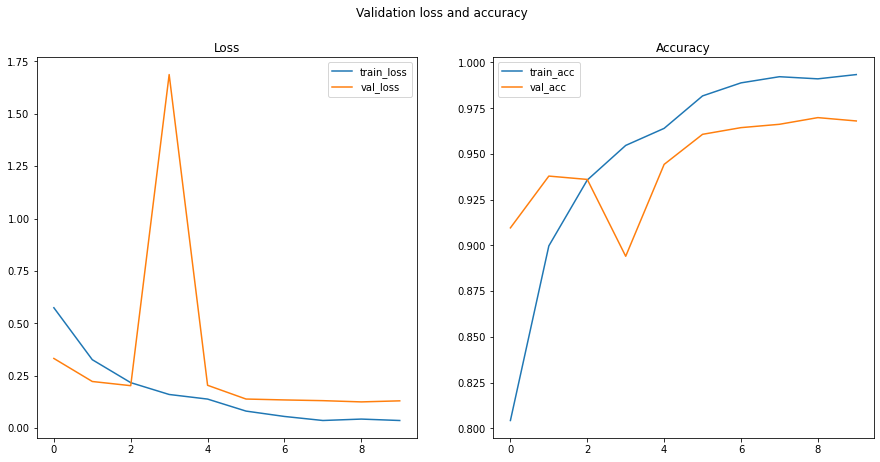

train_time = 5736.605759143829


In [ ]:
# имя для сохраненяемой модели
model_name = 'model_efficientnet_v2_m_ft'

# куда сохраняем модель
PATH_TO_SAVE_MODEL = PROJECT_PATH + model_name + '.pt'

# куда сохр историю
PATH_TO_SAVE_HISTORY = PROJECT_PATH + 'history_' + model_name + '.pt'

# лосс
criterion = nn.CrossEntropyLoss()

# optimizer
# model.classifier[1].parameters(), - feature extraction, model.parameters() -> fine tuning
optimizer = torch.optim.Adam(model.parameters(), amsgrad = True, weight_decay = 1e-5, lr = 1e-3)

# scheduler
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma=0.1)

# размер батча
batch_size = 10

# количество эпох
epochs = 10

# обучение
history, train_time_efficientnet_v2_m_ft = train(train_data, val_data, model=model, optimizer = optimizer,
                criterion = criterion, epochs=epochs, batch_size=batch_size, 
                path_to_save_model = PATH_TO_SAVE_MODEL, path_to_save_history = PATH_TO_SAVE_HISTORY,
                sampler = train_sampler, scheduler = scheduler, is_inception = False)

train_time_efficientnet_v2_m_fe = 1691.8883724212646
train_time_efficientnet_v2_m_ft = 5736.605759143829

In [ ]:
train_time_efficientnet_v2_m_fe = 1691.8883724212646
train_time_efficientnet_v2_m_ft = 5736.605759143829

## Загрузка истории

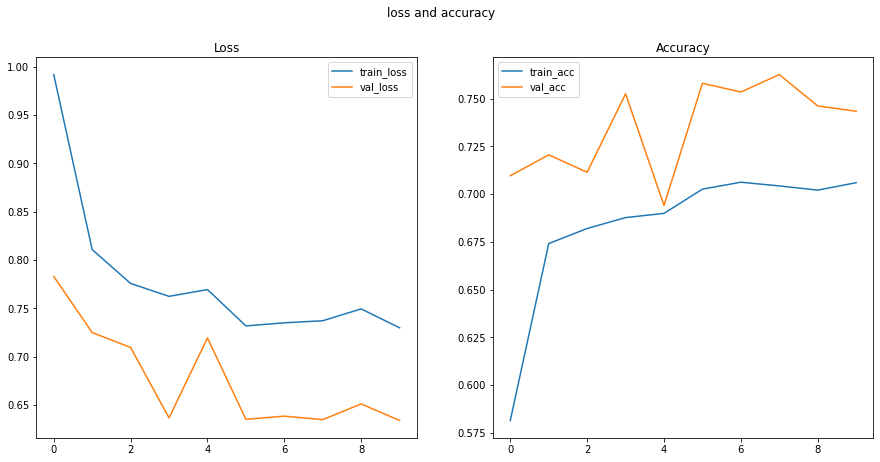

In [ ]:
load_and_plot_history('model_efficientnet_v2_m_fe')

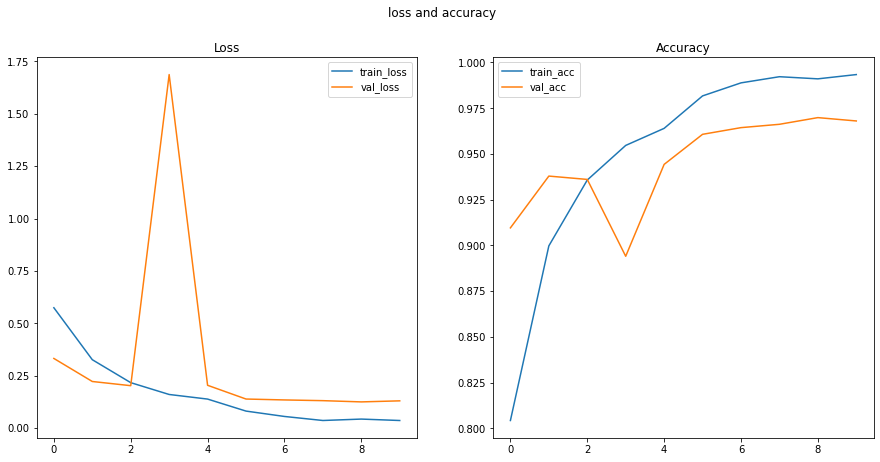

In [ ]:
load_and_plot_history('model_efficientnet_v2_m_ft')

# 13.Подготовка модели mnasnet1_3

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

These weights improve upon the results of the original paper by using TorchVision’s new [training recipe](https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/).

In [ ]:
# инициализация модели alexnet претренированной
model = models.mnasnet1_3(weights = 'IMAGENET1K_V1')

In [ ]:
# параметры модели
model.parameters

<bound method Module.parameters of MNASNet(
  (layers): Sequential(
    (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(40, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
    (4): BatchNorm2d(40, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(40, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (7): BatchNorm2d(24, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (8): Sequential(
      (0): _InvertedResidual(
        (layers): Sequential(
          (0): Conv2d(24, 72, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(72, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
          (2): ReLU(inpla

In [ ]:
# # убираем обновление градиентов
# for param in model.parameters():
#     param.requires_grad = False

In [ ]:
# количество классов в датасете
num_classes = len(train_data.dataset.classes)
num_classes

4

In [ ]:
# последний слой - классификатор
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [ ]:
# количество признаков на вход новому последнему линейному слою
num_ftrs = model.classifier[1].in_features
num_ftrs

1280

In [ ]:
# заменяем последний слой новым линейным с нужным количеством выходных классов
model.classifier[1] = nn.Linear(num_ftrs, num_classes)

In [ ]:
# получившийся классификатор
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=4, bias=True)
)

Видно что обучаемые параметры это вес и смещение последнего линейного слоя

In [ ]:
# перенос финальной модели на устройство
model.to(device)

MNASNet(
  (layers): Sequential(
    (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(40, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
    (4): BatchNorm2d(40, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(40, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (7): BatchNorm2d(24, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (8): Sequential(
      (0): _InvertedResidual(
        (layers): Sequential(
          (0): Conv2d(24, 72, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(72, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(72, 

In [ ]:
# тест форварда модели
# x = torch.rand(4, 3, 224, 224)
# out = model.forward(x)

## Обучение

In [ ]:
!nvidia-smi

Sun Jan  8 20:47:24 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    25W /  70W |  12038MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
torch.cuda.empty_cache()
gc.collect()

29

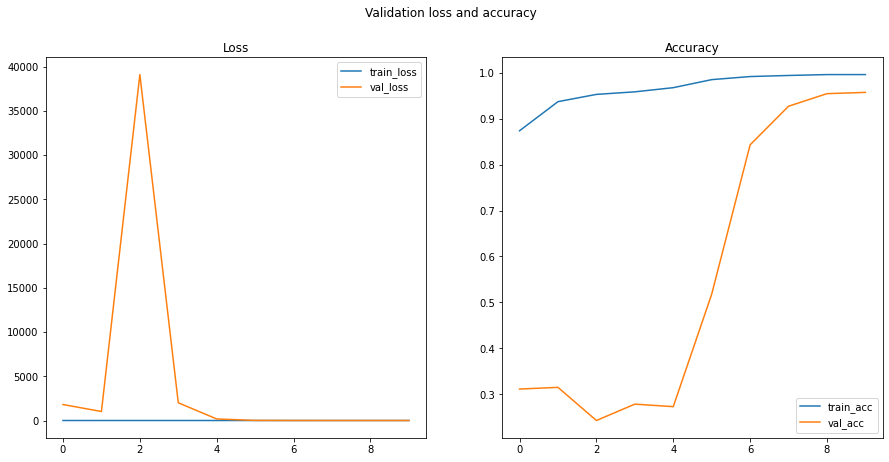

train_time = 794.1448740959167


In [ ]:
# имя для сохраненяемой модели
model_name = 'model_mnasnet1_3_ft'

# куда сохраняем модель
PATH_TO_SAVE_MODEL = PROJECT_PATH + model_name + '.pt'

# куда сохр историю
PATH_TO_SAVE_HISTORY = PROJECT_PATH + 'history_' + model_name + '.pt'

# лосс
criterion = nn.CrossEntropyLoss()

# optimizer
# model.classifier[1].parameters(), - feature extraction, model.parameters() -> fine tuning
optimizer = torch.optim.Adam(model.parameters(), amsgrad = True, weight_decay = 1e-5, lr = 1e-3)

# scheduler
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma=0.1)

# размер батча
batch_size = 10

# количество эпох
epochs = 10

# обучение
history, train_time_mnasnet1_3_ft = train(train_data, val_data, model=model, optimizer = optimizer,
                criterion = criterion, epochs=epochs, batch_size=batch_size, 
                path_to_save_model = PATH_TO_SAVE_MODEL, path_to_save_history = PATH_TO_SAVE_HISTORY,
                sampler = train_sampler, scheduler = scheduler, is_inception = False)

train_time_mnasnet1_3_fe = 638.2685217857361
train_time_mnasnet1_3_ft = 794.1448740959167

In [ ]:
train_time_mnasnet1_3_fe = 638.2685217857361
train_time_mnasnet1_3_ft = 794.1448740959167

## Загрузка истории

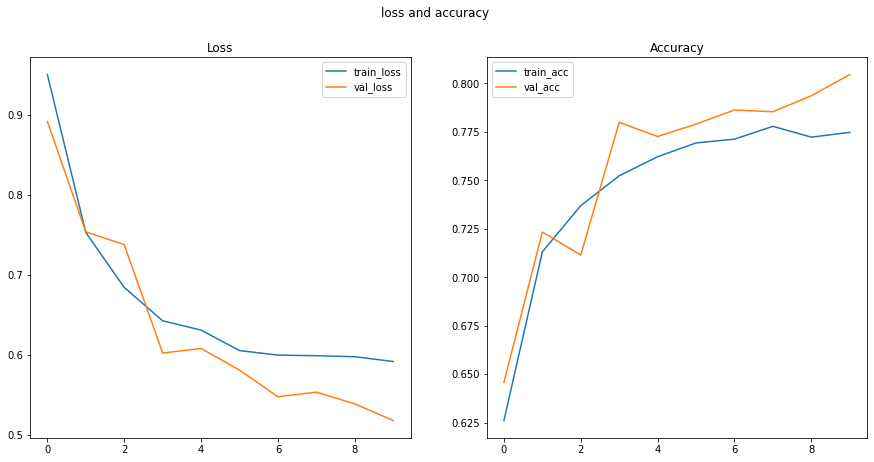

In [ ]:
load_and_plot_history('model_mnasnet1_3_fe')

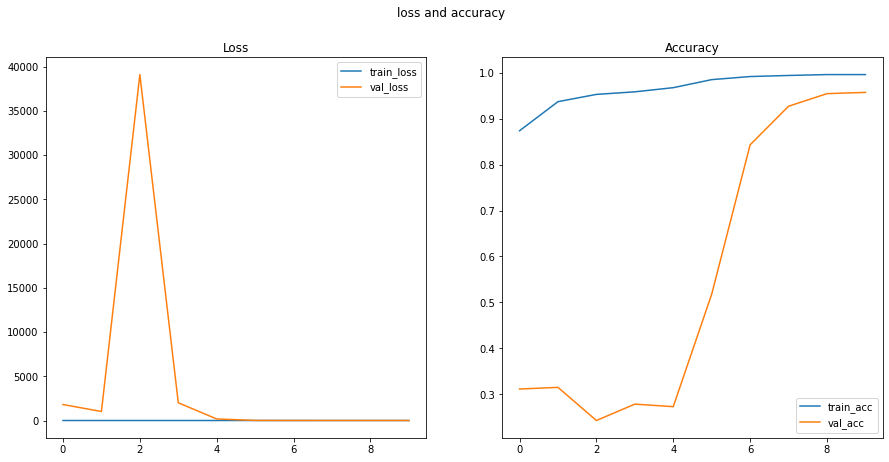

In [ ]:
load_and_plot_history('model_mnasnet1_3_ft')

# 14.Подготовка модели swin_s

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# инициализация модели alexnet претренированной
model = models.swin_s(weights = 'IMAGENET1K_V1')

In [ ]:
# параметры модели
model.parameters

<bound method Module.parameters of SwinTransformer(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): Permute()
      (2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    )
    (1): Sequential(
      (0): SwinTransformerBlock(
        (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (attn): ShiftedWindowAttention(
          (qkv): Linear(in_features=96, out_features=288, bias=True)
          (proj): Linear(in_features=96, out_features=96, bias=True)
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (0): Linear(in_features=96, out_features=384, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=384, out_features=96, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
     

In [ ]:
# # убираем обновление градиентов
# for param in model.parameters():
#     param.requires_grad = False

In [ ]:
# количество классов в датасете
num_classes = len(train_data.dataset.classes)
num_classes

4

In [ ]:
# последний слой - классификатор
model.head

Linear(in_features=768, out_features=1000, bias=True)

In [ ]:
# количество признаков на вход новому последнему линейному слою
num_ftrs = model.head.in_features
num_ftrs

768

In [ ]:
# заменяем последний слой новым линейным с нужным количеством выходных классов
model.head = nn.Linear(num_ftrs, num_classes)

In [ ]:
# получившийся классификатор
model.head

Linear(in_features=768, out_features=4, bias=True)

Видно что обучаемые параметры это вес и смещение последнего линейного слоя

In [ ]:
# перенос финальной модели на устройство
model.to(device)

SwinTransformer(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): Permute()
      (2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    )
    (1): Sequential(
      (0): SwinTransformerBlock(
        (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (attn): ShiftedWindowAttention(
          (qkv): Linear(in_features=96, out_features=288, bias=True)
          (proj): Linear(in_features=96, out_features=96, bias=True)
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (0): Linear(in_features=96, out_features=384, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=384, out_features=96, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (1): SwinTransformerBlock(
       

In [ ]:
# тест форварда модели
# x = torch.rand(4, 3, 224, 224)
# out = model.forward(x)

## Обучение

In [ ]:
!nvidia-smi

Sun Jan  8 22:38:33 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P0    27W /  70W |  12050MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
torch.cuda.empty_cache()
gc.collect()

59240

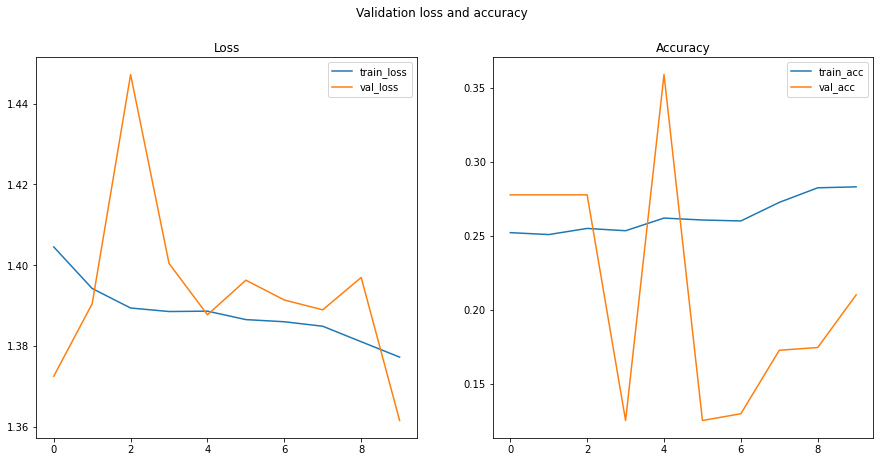

train_time = 3614.440041065216


In [ ]:
# имя для сохраненяемой модели
model_name = 'model_swin_s_ft'

# куда сохраняем модель
PATH_TO_SAVE_MODEL = PROJECT_PATH + model_name + '.pt'

# куда сохр историю
PATH_TO_SAVE_HISTORY = PROJECT_PATH + 'history_' + model_name + '.pt'

# лосс
criterion = nn.CrossEntropyLoss()

# optimizer
# model.head.parameters(), - feature extraction, model.parameters() -> fine tuning
optimizer = torch.optim.Adam(model.parameters(), amsgrad = True, weight_decay = 1e-5, lr = 1e-3)

# scheduler
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma=0.1)

# размер батча
batch_size = 10

# количество эпох
epochs = 10

# обучение
history, train_time_swin_s_ft = train(train_data, val_data, model=model, optimizer = optimizer,
                criterion = criterion, epochs=epochs, batch_size=batch_size, 
                path_to_save_model = PATH_TO_SAVE_MODEL, path_to_save_history = PATH_TO_SAVE_HISTORY,
                sampler = train_sampler, scheduler = scheduler, is_inception = False)

train_time_swin_s_fe = 1344.85378074646
train_time_swin_s_ft = 3614.440041065216

In [ ]:
train_time_swin_s_fe = 1344.85378074646
train_time_swin_s_ft = 3614.440041065216

## Загрузка истории

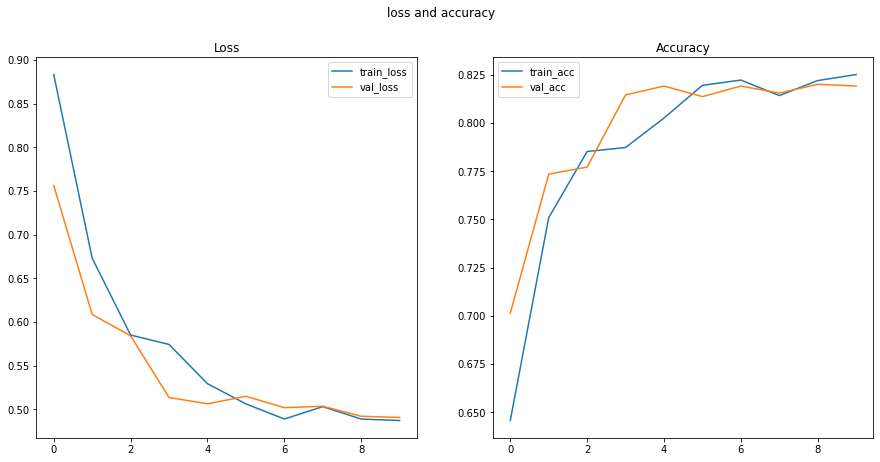

In [ ]:
load_and_plot_history('model_swin_s_fe')

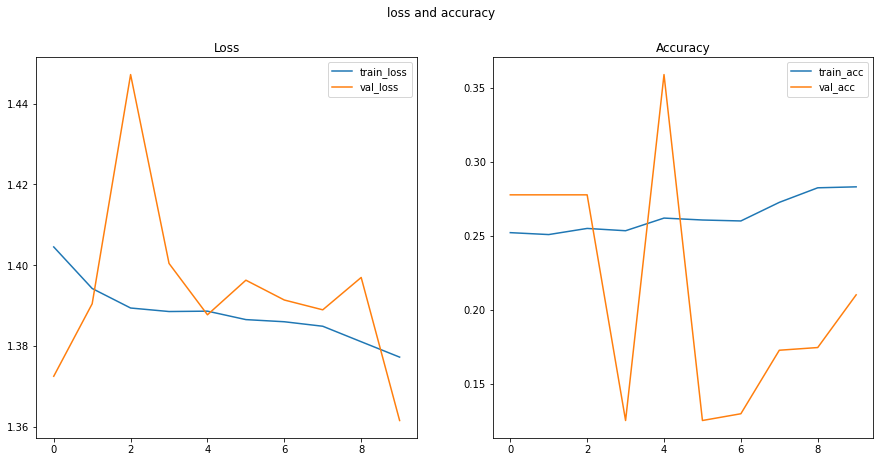

In [ ]:
load_and_plot_history('model_swin_s_ft')

# 14.Анализ данных

In [ ]:
model_names = [
    'model_alexnet_fe',
    'model_alexnet_ft',
    'model_convnext_base_fe',
    'model_convnext_base_ft',
    'model_vgg11_bn_fe',
    'model_vgg11_bn_ft',
    'model_resnet152_fe',
    'model_resnet152_ft',
    'model_densenet161_fe',
    'model_densenet161_ft',
    'model_inception_v3_fe',
    'model_inception_v3_ft',
    'model_mobilenet_v3_large_fe',
    'model_mobilenet_v3_large_ft',
    'model_efficientnet_v2_m_fe',
    'model_efficientnet_v2_m_ft',
    'model_mnasnet1_3_fe',
    'model_mnasnet1_3_ft',
    'model_swin_s_fe',
    'model_swin_s_ft'
]

In [ ]:
def get_history(model_name):

    # загрузка истории
    PATH_TO_MODEL = PROJECT_PATH + 'history_' + model_name + '.pt'
    checkpoint = torch.load(PATH_TO_MODEL)
    history = checkpoint['history']

    return history

In [ ]:
def unpack_history(history):

  train_loss = []
  train_acc = []
  val_loss = []
  val_acc = []

  for h in history:
    train_loss.append(h[0])
    train_acc.append(h[1])
    val_loss.append(h[2])
    val_acc.append(h[3])

  return train_loss, train_acc, val_loss, val_acc

In [ ]:
def plot_val_acc(model_names:list, to_plot:list, model_endswith = None):
    """ to_plot can be [train_loss,train_acc,val_loss,val_acc] """

    fig, ax = plt.subplots(1,figsize=(15, 10))
    fig.suptitle('Results')
    ax.set_title('Metrics for different models on 10 epochs')
    ax.set_ylabel(to_plot)
    ax.set_xlabel('epochs')
      
    for model_name in model_names:
      
      if model_endswith == None: 
        
        if model_name.endswith('fe'):
          marker = 'o'
          ls = None
        else:
          marker = None
          ls = '--'

        history = get_history(model_name)

        train_loss,train_acc,val_loss,val_acc = unpack_history(history)

        for metric_to_plot in to_plot:
          if metric_to_plot == 'train_loss':
            metric = train_loss
          elif metric_to_plot == 'train_acc':
            metric = train_acc        
          elif metric_to_plot == 'val_loss':
            metric = val_loss 
          elif metric_to_plot == 'val_acc':
            metric = val_acc

          ax.plot(metric, label = model_name, marker = marker, ls = ls)

      elif model_name.endswith(model_endswith):

        if model_name.endswith('fe'):
          marker = 'o'
          ls = None
        else:
          marker = None
          ls = '--'

        history = get_history(model_name)

        train_loss,train_acc,val_loss,val_acc = unpack_history(history)

        for metric_to_plot in to_plot:
          if metric_to_plot == 'train_loss':
            metric = train_loss
          elif metric_to_plot == 'train_acc':
            metric = train_acc        
          elif metric_to_plot == 'val_loss':
            metric = val_loss 
          elif metric_to_plot == 'val_acc':
            metric = val_acc

          ax.plot(metric, label = model_name, marker = marker, ls = ls)       


    ax.legend(bbox_to_anchor=(1, 1))
    plt.show()

## График val_acc моделей  fe и ft

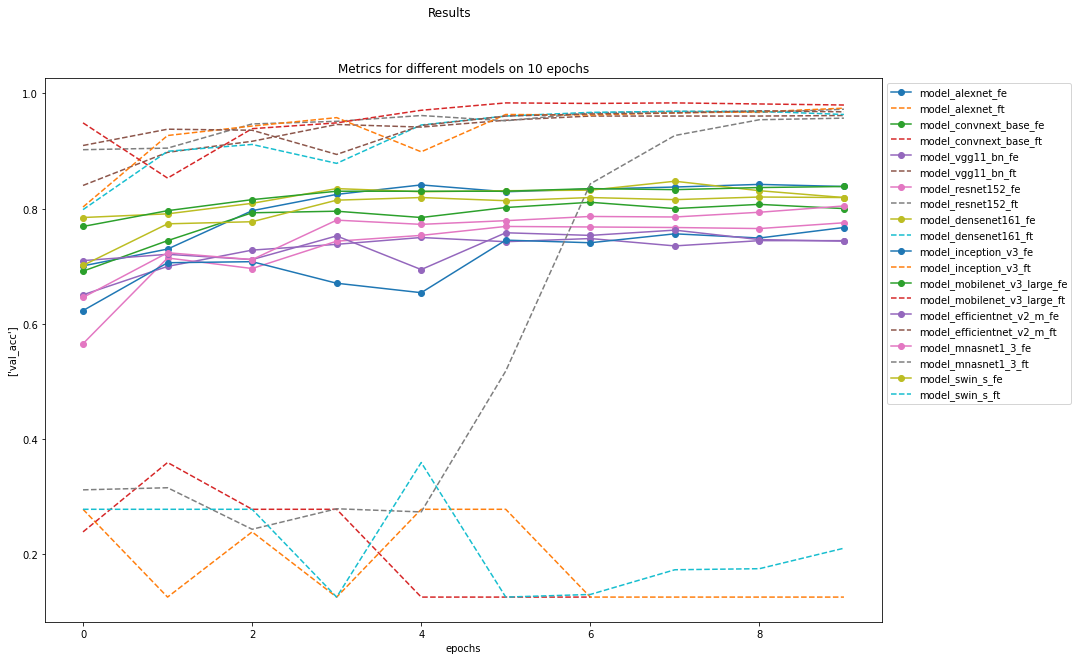

In [ ]:
to_plot = ['val_acc']
plot_val_acc(model_names,to_plot)

**На этом графике я хочу показать, как различаются val_accuracy для 2х способов transfer learning: fine tuning and feature extraction**

1. Видно, что во всех случаях feature extraction показывает стабильные результаты, accuracy не скачет в большом диапазоне.

2. Результаты ft моделей показываеют в среднем результат лучший против fe моделей. Среднее значение

2. Для fine tuning несколько моделей показали плохие результаты (model_densenet161_ft, model_inception_v3_ft, model_mobilenet_v3_large_ft)

3. Одна модель mnasnet1_3_ft сначала показала плохие результаты на первых пяти эпохах, а дальше по качеству стала как остальные ft модели

## График по отдельности моделей fe и ft:

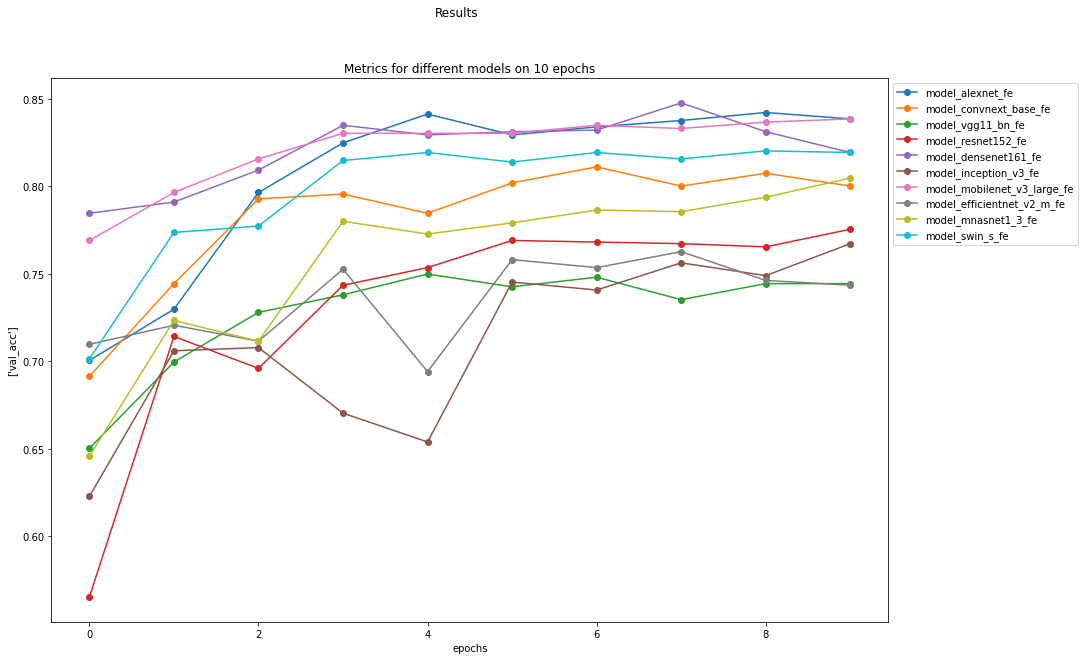

In [ ]:
to_plot = ['val_acc']
plot_val_acc(model_names,to_plot, model_endswith = 'fe')

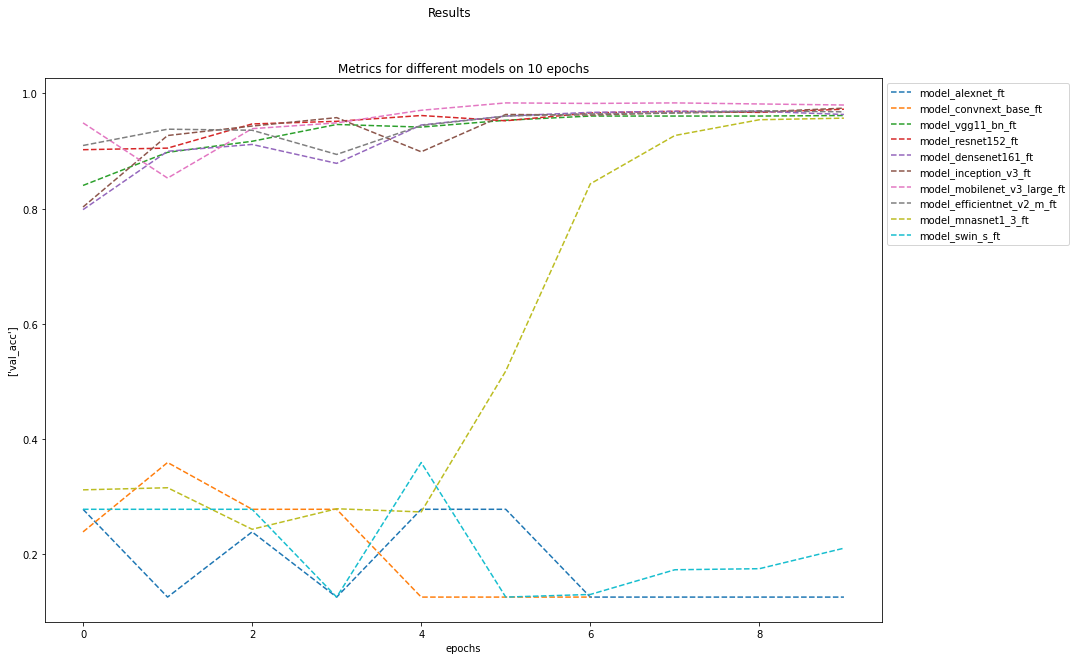

In [ ]:
to_plot = ['val_acc']
plot_val_acc(model_names,to_plot, model_endswith = 'ft')

## Средние значения у FE и FT

In [ ]:
fe_models = [
    'model_alexnet_fe',
    'model_convnext_base_fe',
    'model_vgg11_bn_fe',
    'model_resnet152_fe',
    'model_densenet161_fe',
    'model_inception_v3_fe',
    'model_mobilenet_v3_large_fe',
    'model_efficientnet_v2_m_fe',
    'model_mnasnet1_3_fe',
    'model_swin_s_fe',
]

In [ ]:
ft_models = [
    'model_alexnet_ft',
    'model_convnext_base_ft',
    'model_vgg11_bn_ft',
    'model_resnet152_ft',
    'model_densenet161_ft',
    'model_inception_v3_ft',
    'model_mobilenet_v3_large_ft',
    'model_efficientnet_v2_m_ft',
    'model_efficientnet_v2_m_ft',
    'model_swin_s_ft'
]

In [ ]:
def mean_finder(model_name):
  history = get_history(model_name)
  _,_,_,val_acc = unpack_history(history)
  mean_val_acc = np.array(val_acc).mean()
  return mean_val_acc

In [ ]:
mean_val_acc_fe = []
for model_name in fe_models:
  mean_val_acc_fe.append(mean_finder(model_name))
mean_val_acc_fe

[0.8073059360730594,
 0.7828310502283105,
 0.727945205479452,
 0.731689497716895,
 0.8209132420091324,
 0.7118721461187214,
 0.8213698630136987,
 0.7351598173515981,
 0.7581735159817352,
 0.7973515981735159]

Среднее значение val_acc у  FE моделей

In [ ]:
np.mean(mean_val_acc_fe)

0.7694611872146118

In [ ]:
mean_val_acc_ft = []
for model_name in ft_models:
  mean_val_acc_ft.append(mean_finder(model_name))
mean_val_acc_ft

[0.18219178082191784,
 0.2182648401826484,
 0.933972602739726,
 0.9494977168949772,
 0.9262100456621006,
 0.9364383561643834,
 0.9571689497716894,
 0.9451141552511416,
 0.9451141552511416,
 0.2128767123287671]

Среднее значение val_acc у  FT моделей + выкинул аномальные

In [ ]:
np.mean(mean_val_acc_ft[2:9])

0.9419308545335943

С аномалиями

In [ ]:
np.mean(mean_val_acc_ft)

0.7206849315068493

##  Соберу данные в таблицу

Чтобы удобно было работать с ними

### Найду максимальные значения accuracy для каждой из моделей

In [ ]:
def max_finder(model_name):
  history = get_history(model_name)
  _,_,_,val_acc = unpack_history(history)
  max_val_acc = np.array(val_acc).max()
  return max_val_acc

In [ ]:
# максимальное значение accuracy для каждой модели по порядку из списка
max_val_acc = []
for model_name in model_names:
  max_val_acc.append(max_finder(model_name))
max_val_acc

[0.8420091324200913,
 0.2776255707762557,
 0.810958904109589,
 0.3589041095890411,
 0.7497716894977169,
 0.9616438356164384,
 0.7753424657534247,
 0.9726027397260274,
 0.8474885844748858,
 0.9689497716894977,
 0.7671232876712328,
 0.9744292237442922,
 0.8383561643835616,
 0.9835616438356164,
 0.7625570776255708,
 0.9698630136986301,
 0.8045662100456621,
 0.9570776255707762,
 0.8200913242009132,
 0.3589041095890411]

### Соберу в массив время тренировки каждой модели

In [ ]:
train_time_alexnet_fe = 1086.8976394875695
train_time_alexnet_ft = 1106.1522331237793
train_time_convnext_base_fe = 2214.3288333415985
train_time_convnext_base_ft = 10013.9873250963242
train_time_vgg11_bn_fe = 772.2326216697693
train_time_vgg11_bn_ft = 1934.7628409862518
train_time_resnet152_fe = 1293.1927645206451
train_time_resnet152_ft = 3814.0271854400635
train_time_densenet161_fe = 1227.209811925888
train_time_densenet161_ft = 3522.60404586792
train_time_inception_v3_fe = 842.6096646785736
train_time_inception_v3_ft = 2300.269156932831
train_time_mobilenet_v3_large_fe = 870.0678339004517
train_time_mobilenet_v3_large_ft = 933.6277282238007
train_time_efficientnet_v2_m_fe = 1691.8883724212646
train_time_efficientnet_v2_m_ft = 5736.605759143829
train_time_mnasnet1_3_fe = 638.2685217857361
train_time_mnasnet1_3_ft = 794.1448740959167
train_time_swin_s_fe = 1344.85378074646
train_time_swin_s_ft = 3614.440041065216

In [ ]:
traing_time = [
    train_time_alexnet_fe,
    train_time_alexnet_ft,
    train_time_convnext_base_fe,
    train_time_convnext_base_ft,
    train_time_vgg11_bn_fe,
    train_time_vgg11_bn_ft,
    train_time_resnet152_fe,
    train_time_resnet152_ft,
    train_time_densenet161_fe,
    train_time_densenet161_ft,
    train_time_inception_v3_fe,
    train_time_inception_v3_ft,
    train_time_mobilenet_v3_large_fe,
    train_time_mobilenet_v3_large_ft,
    train_time_efficientnet_v2_m_fe,
    train_time_efficientnet_v2_m_ft,
    train_time_mnasnet1_3_fe,
    train_time_mnasnet1_3_ft,
    train_time_swin_s_fe,
    train_time_swin_s_ft,
]

### Год модели

In [ ]:
year = [
    2012,
    2012,
    2020,
    2020,
    2014,
    2014,
    2015,
    2015,
    2016,
    2016,
    2015,
    2015,
    2019,
    2019,
    2021,
    2021,
    2018,
    2018,
    2021,
    2021
]

### Количество параметров у модели

In [ ]:
params = [
    61.1e6,
    61.1e6,
    88.8e6,
    88.8e6,
    132.9e6,
    132.9e6,
    60.2e6,
    60.2e6,
    28.7e6,
    28.7e6,
    27.2e6,
    27.2e6,
    5.5e6,
    5.5e6,
    54.1e6,
    54.1e6,
    6.3e6,
    6.3e6,
    49.6e6,
    49.6e6
]

### Размер получившейся модели

In [ ]:
size = [
    217.7,
    870.1,
    334.2,
    1310.0,
    491.5,
    1920.0,
    222.8,
    888.7,
    102.3,
    405.8,
    93.4,
    372.3,
    16.3,
    64.6,
    203.2,
    808.9,
    19.4,
    76.9,
    186.9,
    746.2
]

### model type

Feature extraction or fine tuning

In [ ]:
model_type = [
    'fe',
    'ft',
    'fe',
    'ft',
    'fe',
    'ft',
    'fe',
    'ft',
    'fe',
    'ft',
    'fe',
    'ft',
    'fe',
    'ft',
    'fe',
    'ft',
    'fe',
    'ft',
    'fe',
    'ft'
]

### Соберу в DataFrame

In [ ]:
dict_to_df = {
    'model_name':model_names,
    'max_val_acc':max_val_acc,
    'training_time':traing_time,
    'size':size,
    'year':year,
    'params':params,
    'model_type':model_type
}

In [ ]:
df = pd.DataFrame(dict_to_df)
df

model_name  max_val_acc  training_time    size  year  \
0              model_alexnet_fe     0.842009    1086.897639   217.7  2012   
1              model_alexnet_ft     0.277626    1106.152233   870.1  2012   
2        model_convnext_base_fe     0.810959    2214.328833   334.2  2020   
3        model_convnext_base_ft     0.358904   10013.987325  1310.0  2020   
4             model_vgg11_bn_fe     0.749772     772.232622   491.5  2014   
5             model_vgg11_bn_ft     0.961644    1934.762841  1920.0  2014   
6            model_resnet152_fe     0.775342    1293.192765   222.8  2015   
7            model_resnet152_ft     0.972603    3814.027185   888.7  2015   
8          model_densenet161_fe     0.847489    1227.209812   102.3  2016   
9          model_densenet161_ft     0.968950    3522.604046   405.8  2016   
10        model_inception_v3_fe     0.767123     842.609665    93.4  2015   
11        model_inception_v3_ft     0.974429    2300.269157   372.3  2015   
12  model_mobilenet_v3_large_fe     0.838356     870.067834    16.3  2019   
13  model_mobilenet_v3_large_ft     0.983562     933.627728    64.6  2019   
14   model_efficientnet_v2_m_fe     0.762557    1691.888372   203.2  2021   
15   model_efficientnet_v2_m_ft     0.969863    5736.605759   808.9  2021   
16          model_mnasnet1_3_fe     0.804566     638.268522    19.4  2018   
17          model_mnasnet1_3_ft     0.957078     794.144874    76.9  2018   
18              model_swin_s_fe     0.820091    1344.853781   186.9  2021   
19              model_swin_s_ft     0.358904    3614.440041   746.2  2021   

         params model_type  
0    61100000.0         fe  
1    61100000.0         ft  
2    88800000.0         fe  
3    88800000.0         ft  
4   132900000.0         fe  
5   132900000.0         ft  
6    60200000.0         fe  
7    60200000.0         ft  
8    28700000.0         fe  
9    28700000.0         ft  
10   27200000.0         fe  
11   27200000.0         ft  
12    5500000.0         fe  
13    5500000.0         ft  
14   54100000.0         fe  
15   54100000.0         ft  
16    6300000.0         fe  
17    6300000.0         ft  
18   49600000.0         fe  
19   49600000.0         ft

In [ ]:
df_fe = df[df.model_type == 'fe']
df_fe

model_name  max_val_acc  training_time   size  year  \
0              model_alexnet_fe     0.842009    1086.897639  217.7  2012   
2        model_convnext_base_fe     0.810959    2214.328833  334.2  2020   
4             model_vgg11_bn_fe     0.749772     772.232622  491.5  2014   
6            model_resnet152_fe     0.775342    1293.192765  222.8  2015   
8          model_densenet161_fe     0.847489    1227.209812  102.3  2016   
10        model_inception_v3_fe     0.767123     842.609665   93.4  2015   
12  model_mobilenet_v3_large_fe     0.838356     870.067834   16.3  2019   
14   model_efficientnet_v2_m_fe     0.762557    1691.888372  203.2  2021   
16          model_mnasnet1_3_fe     0.804566     638.268522   19.4  2018   
18              model_swin_s_fe     0.820091    1344.853781  186.9  2021   

         params model_type  
0    61100000.0         fe  
2    88800000.0         fe  
4   132900000.0         fe  
6    60200000.0         fe  
8    28700000.0         fe  
10   27200000.0         fe  
12    5500000.0         fe  
14   54100000.0         fe  
16    6300000.0         fe  
18   49600000.0         fe

In [ ]:
df_ft = df[df.model_type == 'ft']
df_ft

model_name  max_val_acc  training_time    size  year  \
1              model_alexnet_ft     0.277626    1106.152233   870.1  2012   
3        model_convnext_base_ft     0.358904   10013.987325  1310.0  2020   
5             model_vgg11_bn_ft     0.961644    1934.762841  1920.0  2014   
7            model_resnet152_ft     0.972603    3814.027185   888.7  2015   
9          model_densenet161_ft     0.968950    3522.604046   405.8  2016   
11        model_inception_v3_ft     0.974429    2300.269157   372.3  2015   
13  model_mobilenet_v3_large_ft     0.983562     933.627728    64.6  2019   
15   model_efficientnet_v2_m_ft     0.969863    5736.605759   808.9  2021   
17          model_mnasnet1_3_ft     0.957078     794.144874    76.9  2018   
19              model_swin_s_ft     0.358904    3614.440041   746.2  2021   

         params model_type  
1    61100000.0         ft  
3    88800000.0         ft  
5   132900000.0         ft  
7    60200000.0         ft  
9    28700000.0         ft  
11   27200000.0         ft  
13    5500000.0         ft  
15   54100000.0         ft  
17    6300000.0         ft  
19   49600000.0         ft

## Лучшая модель FE

In [ ]:
df_fe.loc[df_fe.max_val_acc.idxmax()]

model_name       model_densenet161_fe
max_val_acc                  0.847489
training_time             1227.209812
size                            102.3
year                             2016
params                     28700000.0
model_type                         fe
Name: 8, dtype: object

## Лучшая модеель FT

In [ ]:
df_ft.loc[df_ft.max_val_acc.idxmax()]

model_name       model_mobilenet_v3_large_ft
max_val_acc                         0.983562
training_time                     933.627728
size                                    64.6
year                                    2019
params                             5500000.0
model_type                                ft
Name: 13, dtype: object

##  Описательные статистики FE

In [ ]:
df_fe.describe()

max_val_acc  training_time        size         year        params
count    10.000000      10.000000   10.000000    10.000000  1.000000e+01
mean      0.801826    1198.154984  188.770000  2017.100000  5.144000e+07
std       0.035926     477.155159  145.299171     3.142893  3.867931e+07
min       0.749772     638.268522   16.300000  2012.000000  5.500000e+06
25%       0.769178     849.474207   95.625000  2015.000000  2.757500e+07
50%       0.807763    1157.053726  195.050000  2017.000000  5.185000e+07
75%       0.833790    1331.938527  221.525000  2019.750000  6.087500e+07
max       0.847489    2214.328833  491.500000  2021.000000  1.329000e+08

In [ ]:
df_fe.describe()[df_fe.describe().columns[1:]]

training_time        size         year        params
count      10.000000   10.000000    10.000000  1.000000e+01
mean     1198.154984  188.770000  2017.100000  5.144000e+07
std       477.155159  145.299171     3.142893  3.867931e+07
min       638.268522   16.300000  2012.000000  5.500000e+06
25%       849.474207   95.625000  2015.000000  2.757500e+07
50%      1157.053726  195.050000  2017.000000  5.185000e+07
75%      1331.938527  221.525000  2019.750000  6.087500e+07
max      2214.328833  491.500000  2021.000000  1.329000e+08

##  Описательные статистики FT

с аномалиями

In [ ]:
df_ft.describe()

max_val_acc  training_time         size         year        params
count    10.000000      10.000000    10.000000    10.000000  1.000000e+01
mean      0.778356    3377.062119   746.350000  2017.100000  5.144000e+07
std       0.309019    2807.198419   567.986681     3.142893  3.867931e+07
min       0.277626     794.144874    64.600000  2012.000000  5.500000e+06
25%       0.508447    1313.304885   380.675000  2015.000000  2.757500e+07
50%       0.965297    2911.436601   777.550000  2017.000000  5.185000e+07
75%       0.971918    3764.130399   884.050000  2019.750000  6.087500e+07
max       0.983562   10013.987325  1920.000000  2021.000000  1.329000e+08

In [ ]:
df_ft.describe()[df_ft.describe().columns[1:]]

training_time         size         year        params
count      10.000000    10.000000    10.000000  1.000000e+01
mean     3377.062119   746.350000  2017.100000  5.144000e+07
std      2807.198419   567.986681     3.142893  3.867931e+07
min       794.144874    64.600000  2012.000000  5.500000e+06
25%      1313.304885   380.675000  2015.000000  2.757500e+07
50%      2911.436601   777.550000  2017.000000  5.185000e+07
75%      3764.130399   884.050000  2019.750000  6.087500e+07
max     10013.987325  1920.000000  2021.000000  1.329000e+08

Без аномалий

In [ ]:
df_ft.iloc[2:9].describe()

max_val_acc  training_time         size         year        params
count     7.000000       7.000000     7.000000     7.000000  7.000000e+00
mean      0.969733    2719.434513   648.171429  2016.857143  4.498571e+07
std       0.008639    1762.280343   645.883270     2.544836  4.412242e+07
min       0.957078     794.144874    64.600000  2014.000000  5.500000e+06
25%       0.965297    1434.195285   224.600000  2015.000000  1.675000e+07
50%       0.969863    2300.269157   405.800000  2016.000000  2.870000e+07
75%       0.973516    3668.315616   848.800000  2018.500000  5.715000e+07
max       0.983562    5736.605759  1920.000000  2021.000000  1.329000e+08

In [ ]:
df_ft.iloc[2:9].describe()[df_ft.describe().columns[1:]]

training_time         size         year        params
count       7.000000     7.000000     7.000000  7.000000e+00
mean     2719.434513   648.171429  2016.857143  4.498571e+07
std      1762.280343   645.883270     2.544836  4.412242e+07
min       794.144874    64.600000  2014.000000  5.500000e+06
25%      1434.195285   224.600000  2015.000000  1.675000e+07
50%      2300.269157   405.800000  2016.000000  2.870000e+07
75%      3668.315616   848.800000  2018.500000  5.715000e+07
max      5736.605759  1920.000000  2021.000000  1.329000e+08

## Графики

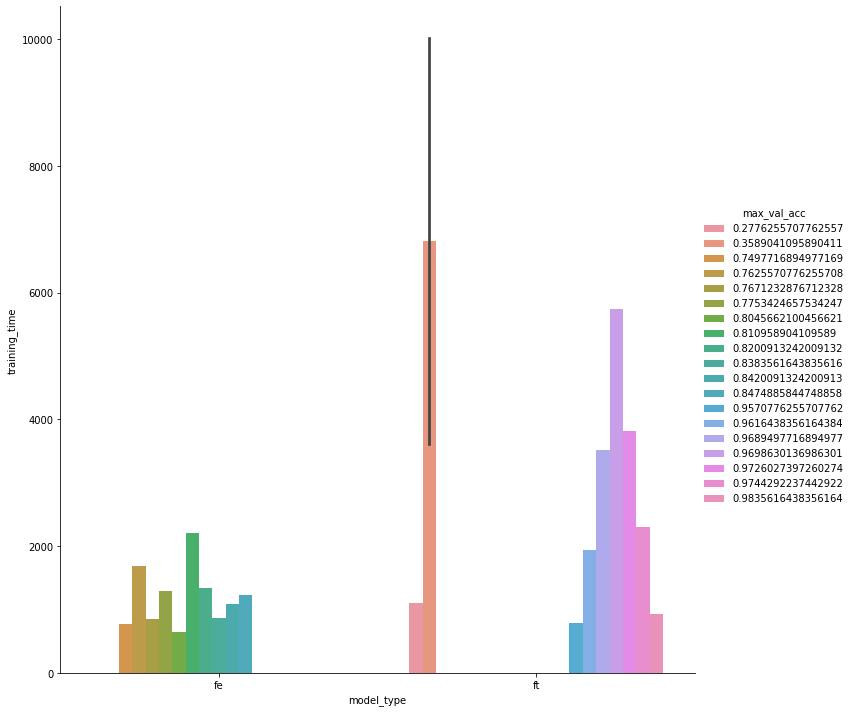

In [ ]:
sns.catplot(
    data=df, kind="bar",
    x="model_type", y="training_time", hue="max_val_acc", alpha=1, height=10
)

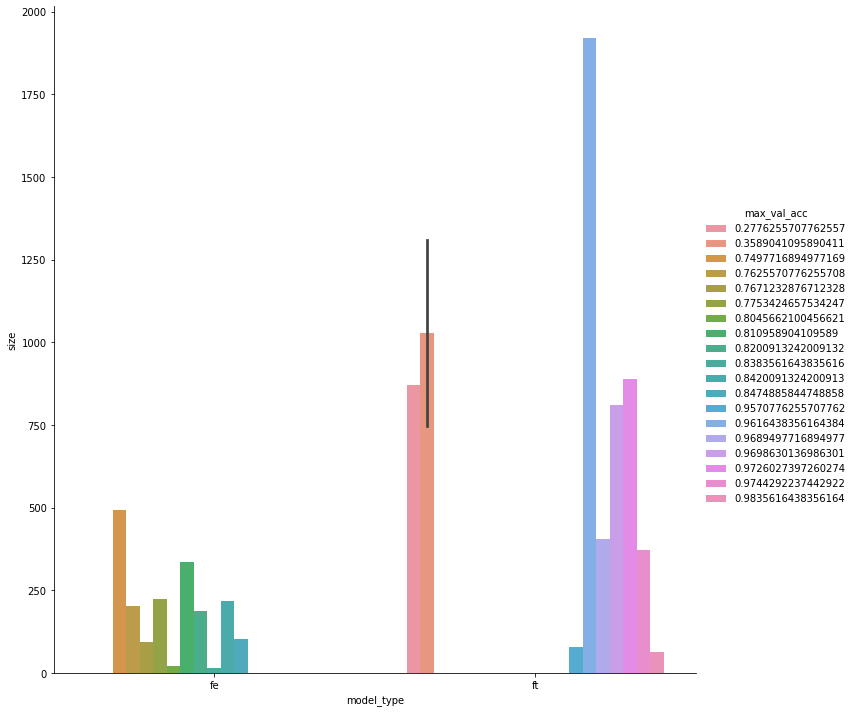

In [ ]:
sns.catplot(
    data=df, kind="bar",
    x="model_type", y="size", hue="max_val_acc", alpha=1, height=10
)

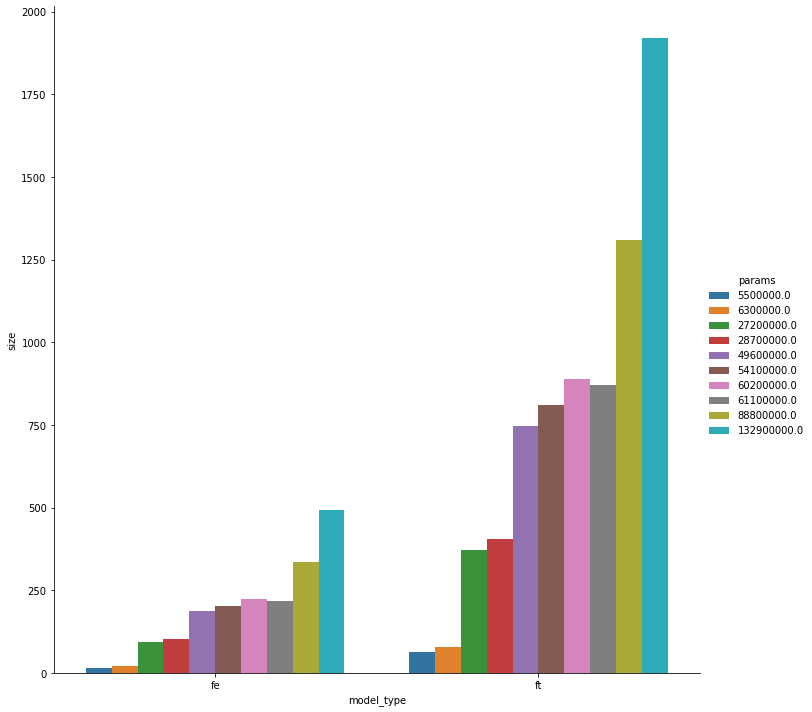

In [ ]:
sns.catplot(
    data=df, kind="bar",
    x="model_type", y="size", hue="params", alpha=1, height=10
)

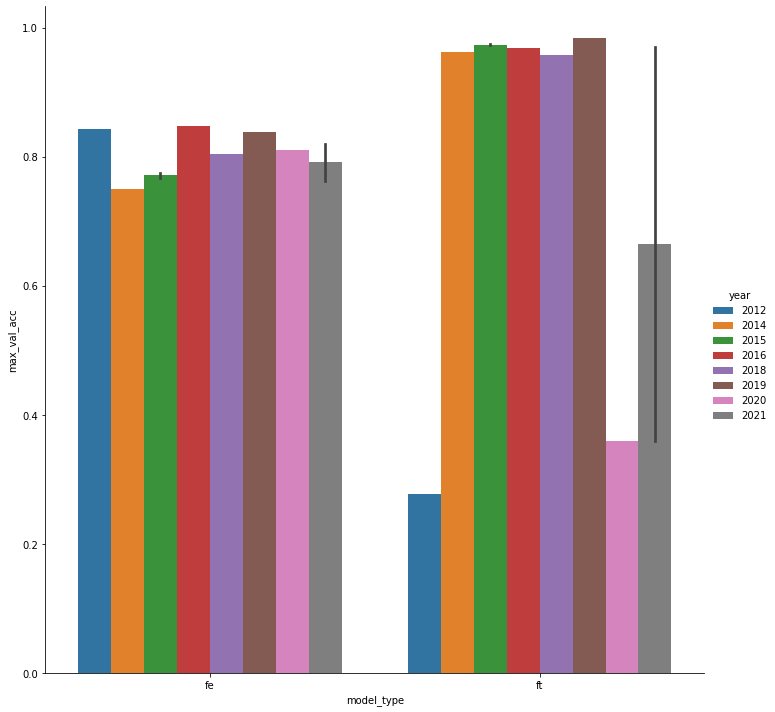

In [ ]:
sns.catplot(
    data=df, kind="bar",
    x="model_type", y="max_val_acc", hue="year", alpha=1, height=10
)

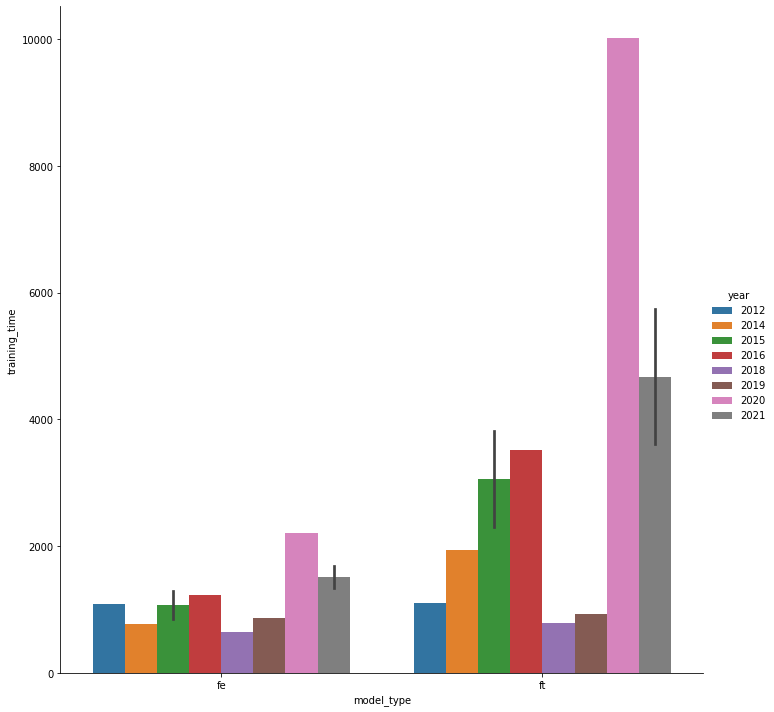

In [ ]:
sns.catplot(
    data=df, kind="bar",
    x="model_type", y="training_time", hue="year", alpha=1, height=10
)

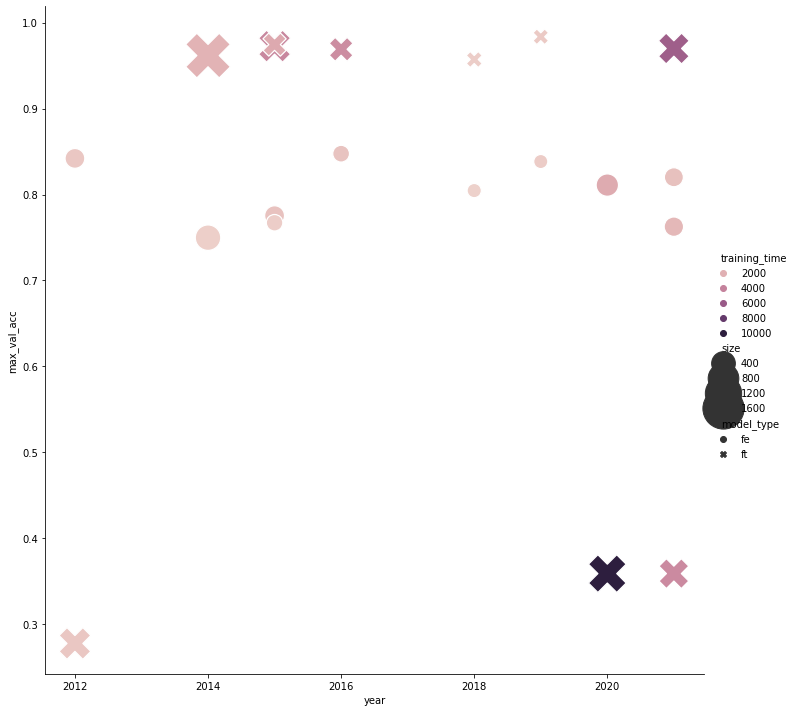

In [ ]:
sns.relplot(
    data=df,
    x='year', y='max_val_acc',
    hue='training_time', size="size",
    sizes=(200, 2000), style = 'model_type',
    height = 10, aspect = 1
    )

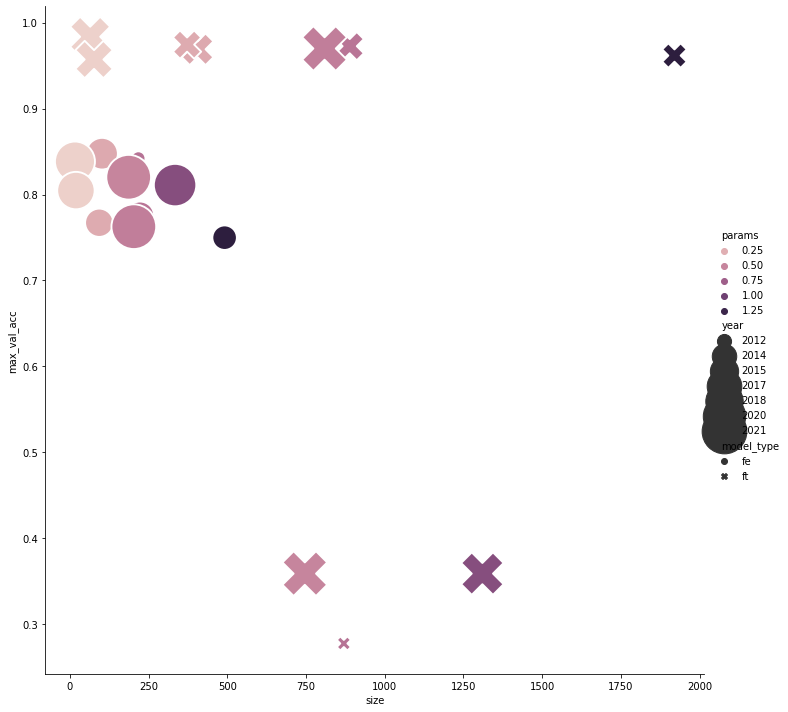

In [ ]:
sns.relplot(
    data=df,
    x='size', y='max_val_acc',
    hue='params', size="year",
    sizes=(200, 2000), style = 'model_type',
    height = 10, aspect = 1
    )

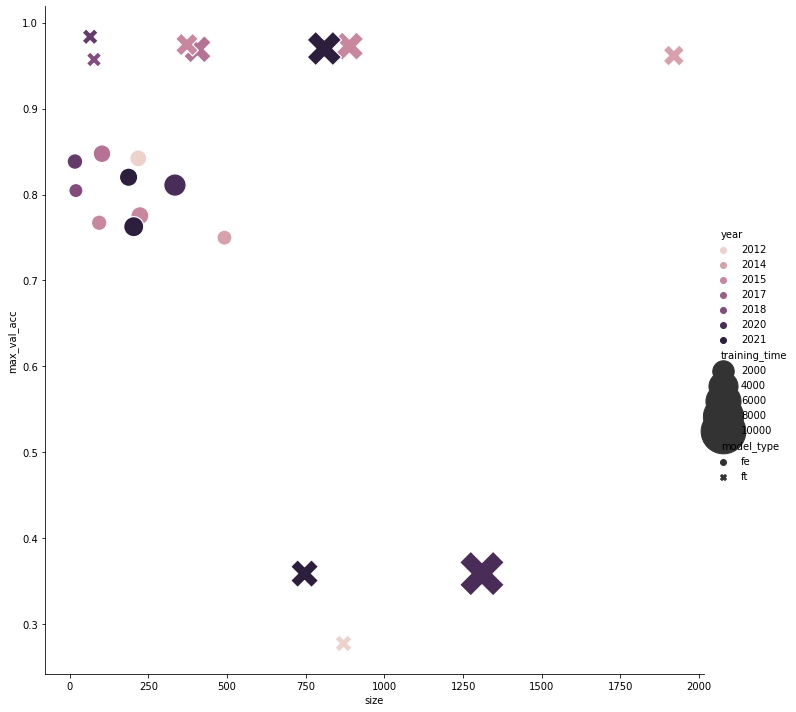

In [ ]:
sns.relplot(
    data=df,
    x='size', y='max_val_acc',
    hue='year', size="training_time",
    sizes=(200, 2000), style = 'model_type',
    height = 10, aspect = 1
    )

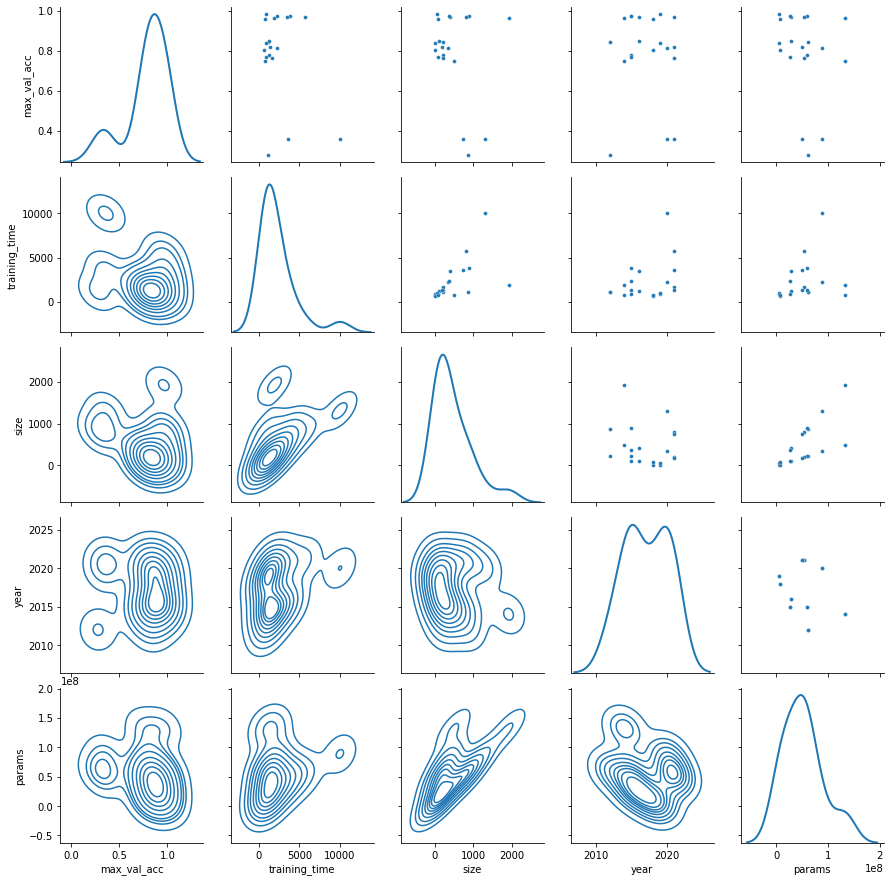

In [ ]:
g = sns.PairGrid(df, diag_sharey=False)
g.map_upper(sns.scatterplot, s=15)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=2)

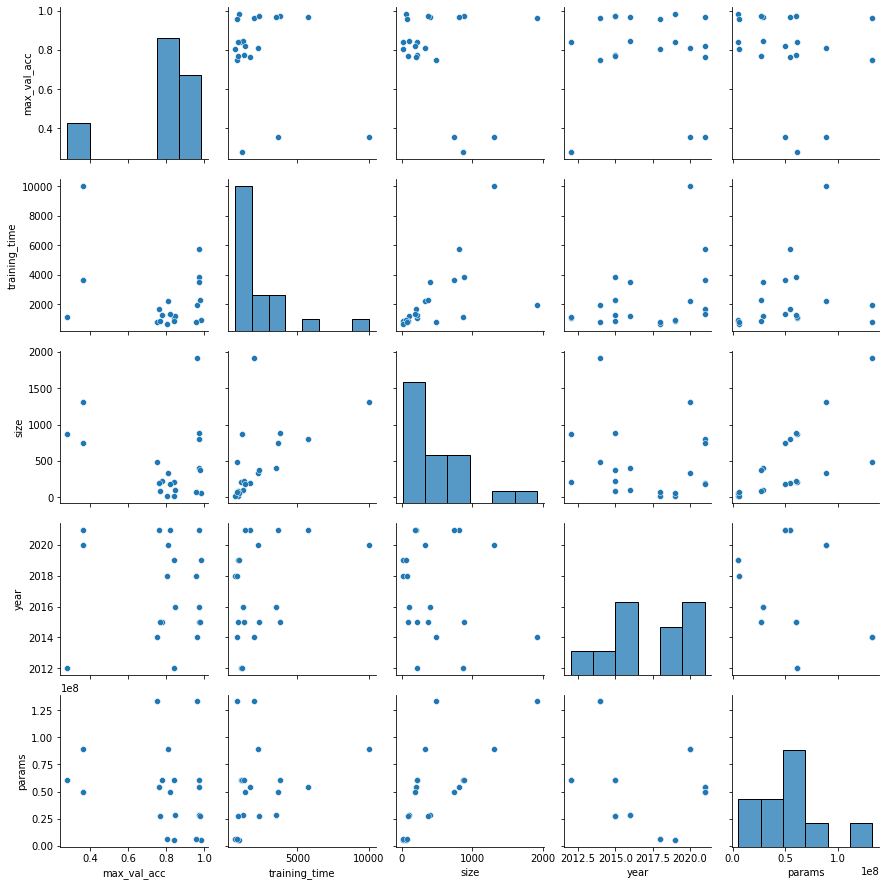

In [ ]:
sns.pairplot(df)

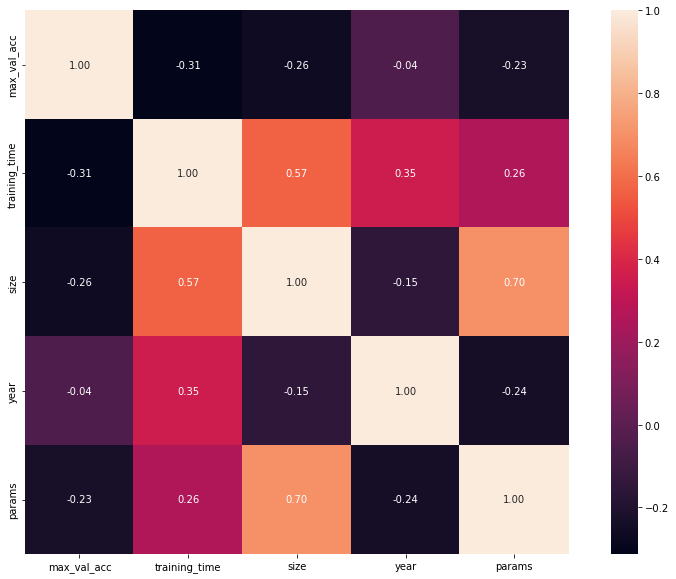

In [ ]:
plt.figure(figsize = (15,10))
sns.heatmap(df.corr(), fmt=".2f", annot=True, square=True)
# plt.show()

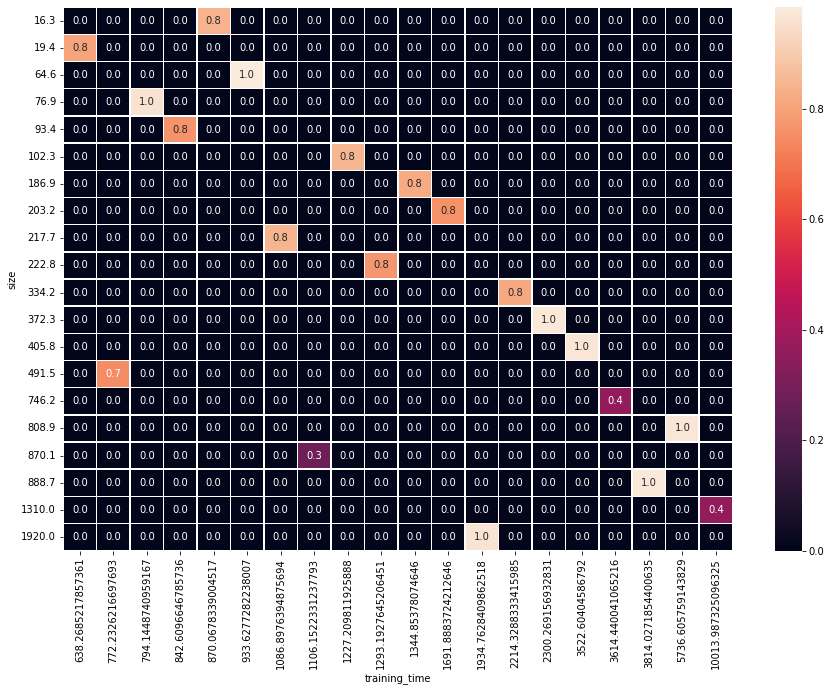

In [ ]:
table = df.pivot_table(
                        index='size', 
                        columns='training_time', 
                        values='max_val_acc',
                        aggfunc=sum).fillna(0)
plt.figure(figsize = (15,10))
sns.heatmap(table, annot=True, fmt=".1f", linewidths=.5)